# Standard Workflow E-MTAB-5061


Raw information was downloaded from the Cell Atlas. 

The different files were just renamed to import them as:

+ matrix.mtx
+ genes.tsv
+ barcodes.tsv

Here some information is not exactly in the format expected. Hence, additional chunks were added to the workflow to:

+ add genes symbol instead of ensembl using mygenes.
+ filtered out genes without symbol



Processed data and annotation was also imported as metadata.tsv.



### Import section ###

In [1]:
import besca as bc
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from scipy import sparse, io
import os
import time
sc.logging.print_versions()

import logging
import seaborn as sns

# for standard processing, set verbosity to minimum
sc.settings.verbosity = 0  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80)
version = '2.8'
start0 = time.time()

-----
anndata     0.7.5
scanpy      1.6.1
sinfo       0.3.1
-----
PIL                 8.1.0
absl                NA
anndata             0.7.5
annoy               NA
attr                20.3.0
backcall            0.2.0
bbknn               NA
besca               2.4+57.g5ad53b2
biothings_client    0.2.1
cached_property     1.5.2
certifi             2020.12.05
cffi                1.14.4
chardet             4.0.0
colorama            0.4.4
constants           NA
cycler              0.10.0
cython_runtime      NA
dask                2021.02.0
dateutil            2.8.1
decorator           4.4.2
deprecate           0.3.0
dominate            2.6.0
fbpca               NA
fsspec              2021.06.1
future_fstrings     NA
get_version         2.1
google              NA
h5py                3.1.0
highs_wrapper       NA
idna                2.10
igraph              0.8.3
importlib_metadata  1.7.0
intervaltree        NA
ipykernel           5.4.2
ipython_genutils    0.2.0
ipywidgets          7.6.3
jedi 

## Setup Standard Wokflow

### Parameters to be set - on the command line or here ###

In [2]:
# decisions to be made
use_example_dataset = False # If True, the pipeline will run using the example dataset shipped with BESCA

species = 'human'
batch_to_correct = 'None' # must be "None" or any one of the labels in "metadata.tsv", ID, SPECIES, TISSUE, DONOR, TREATMENT; typically "ID" or "DONOR"
analysis_name = 'standard_workflow_besca2.0_without_regress_out'
split_condition='Sample Characteristic[individual]' #'experiment' is generally a good default
dynrange=['B2m','Actb','Pgk1','Ctcf'] #genes for which to plot dynamic range
if species=='human': dynrange=[x.upper() for x in dynrange]

#additional labeling
labeling_to_use = 'None' # must be "None" or any one of the labels in "metadata.tsv", ID, SPECIES, TISSUE, DONOR, TREATMENT; typically "ID" or "DONOR"
labeling_name = 'MyAnno' # define name under which the labeling should be exported
labeling_description = 'celltype annotation' #define description which should be saved to labeling_info file
labeling_author = 'author' #define author which should be saved to labeling info file

### Define Input ###

In [3]:
# define filepath (this is the folder that contains "raw" and "analyzed")
root_path = os.getcwd()
root_path

'/pstore/data/bioinfo/users/hatjek/devel/besca_publication_results/pancreas/Segerstolpe2016'

### Standard parameters - these should be kept as stable as possible ###

In [4]:
# the standard parameter section
standard_min_genes = 2000
standard_min_cells = 30
standard_min_counts = 10000
standard_n_genes = 12500 # this is the most tricky one to set
standard_percent_mito = 0.1
standard_max_counts = 2000000 #might be redundant with n_genes

## Standard Pipeline
(note nothing below this point should be modified!!)

In [5]:
# define standardized file paths based on the input above
results_folder = os.path.join(root_path, 'analyzed', analysis_name)
results_file = os.path.join(results_folder, analysis_name + '.h5ad') # specify a .h5ad file for storing the results
log_file = os.path.join(results_folder, analysis_name + '.standard.log') # specify a log file for keeping a short summary and overview
sc.settings.figdir = os.path.join(results_folder, 'figures')

#setup standard workflow (generates output directories and setsup logging file)
bc.st.setup(results_folder, 
          analysis_name, 
          labeling_name, 
          labeling_to_use, 
          log_file, 
          version,
          root_path, 
          species, 
          batch_to_correct, 
          standard_min_genes,
          standard_min_cells,
          standard_min_counts,
          standard_n_genes,
          standard_percent_mito,
          standard_max_counts)

# read input data
#if use_example_dataset:
#    adata = bc.datasets.pbmc_storage_raw()
#else:
#    adata = bc.st.read_matrix(root_path, )
adata = bc.datasets.Segerstolpe2016_processed()
adata = bc.subset_adata(adata, adata.obs_names, raw=True)
adata.raw = adata

LOG MESSAGE: Standard Pipeline Version 2.8 used
LOG MESSAGE: 2021-07-20
LOG MESSAGE: Analysis 'standard_workflow_besca2.0_without_regress_out' on data located in'/pstore/data/bioinfo/users/hatjek/devel/besca_publication_results/pancreas/Segerstolpe2016'
LOG MESSAGE: species: human
LOG MESSAGE: Batch effect to correct: None
LOG MESSAGE: Parameters:
LOG MESSAGE: 	standard_min_genes = 2000
LOG MESSAGE: 	standard_min_cells = 30
LOG MESSAGE: 	standard_min_counts = 10000
LOG MESSAGE: 	standard_n_genes = 12500
LOG MESSAGE: 	standard_max_counts = 2000000
LOG MESSAGE: 	standard_percent_mito = 0.1
LOG MESSAGE: 	Time for creating all output directories and setting up logging: 0.011s


all output directories created successfully


### Visualization of quality control plots and selected filtering parameters

##### Transcript Capture Efficiency
This plot gives you an idea about the sequencing depth and if the sequencing has reached saturation or not.

##### Library Size distribution
This plot gives you an idea about the library size distribution in your dataset before processing.

##### Selected Filtering Parameters

### First filtering on gene and cell counts

### Second filtering on mitochondrial genes, and upper limit for gene number ###

###  Filtered dataset characteristics

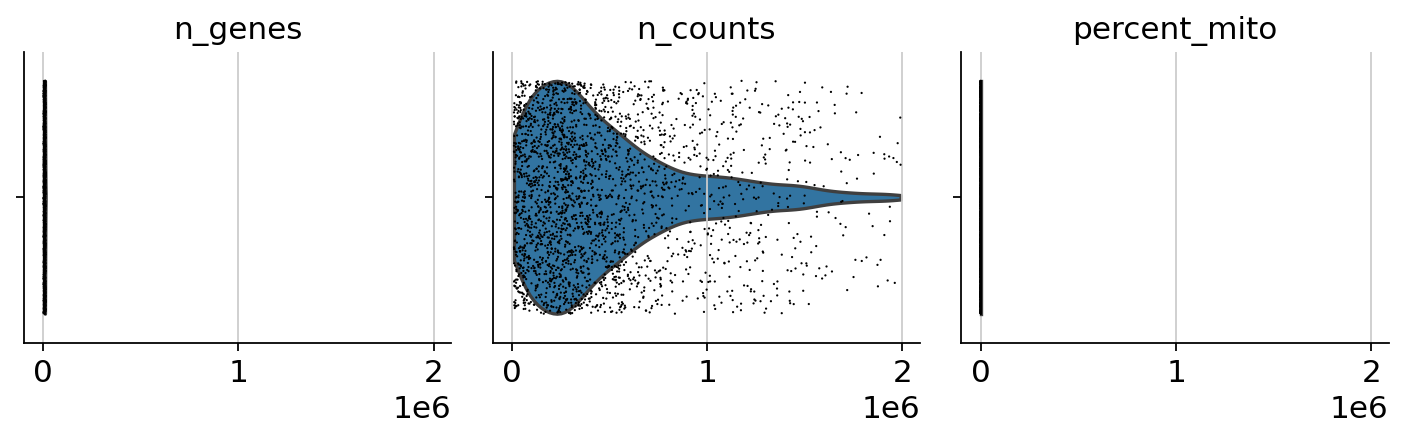

In [6]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'], jitter=0.4, multi_panel=True, save = '.after_filtering.png')

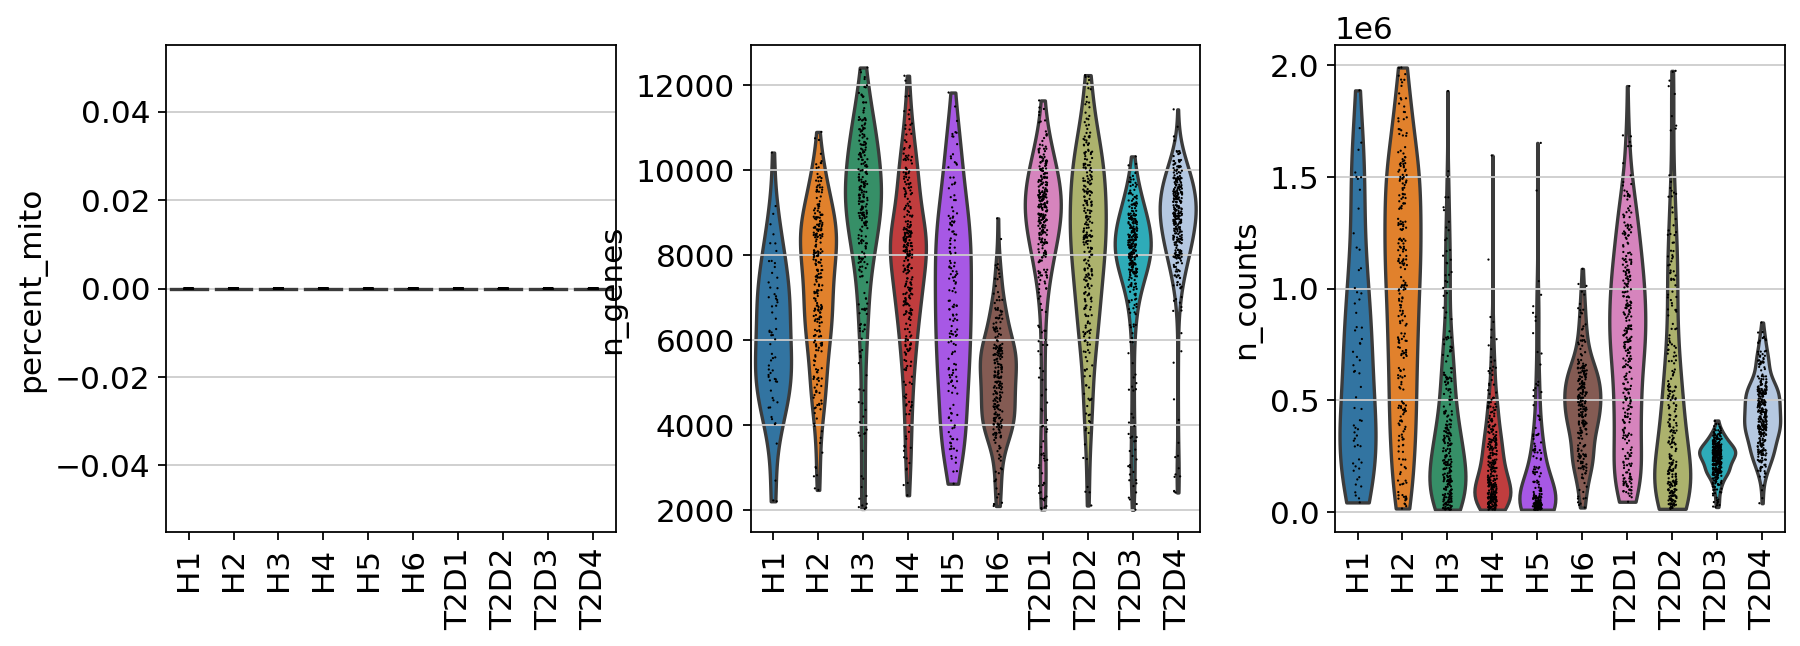

In [7]:
### check mitochondrial reads per sample 
sc.pl.violin(adata, ['percent_mito','n_genes', 'n_counts'], groupby=split_condition,jitter=0.1,rotation=90, save = '.after_filtering.split.png')

### Per-cell normalization, and output of normalized results ###

<Figure size 320x320 with 0 Axes>

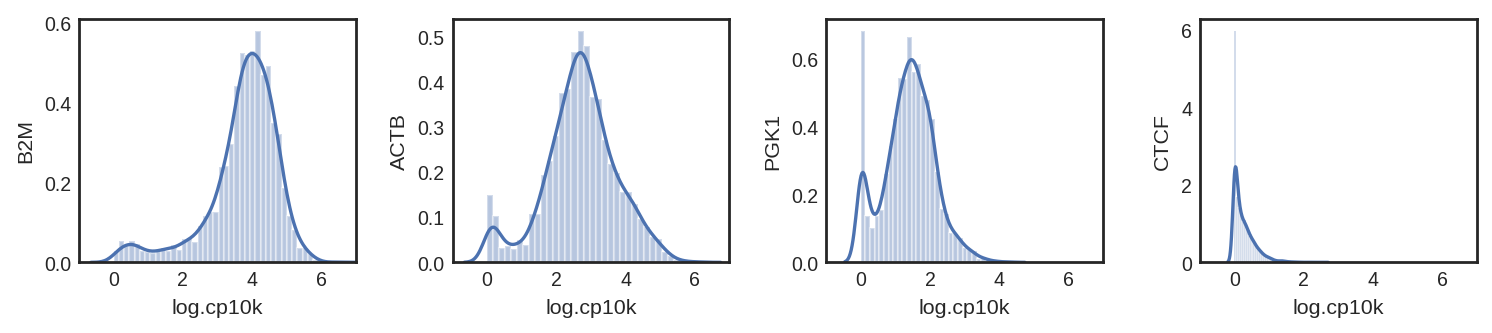

In [8]:
# Further QC: dynamic range of ubi/marker genes
fig = plt.figure()
sns.set(font_scale=0.8)
plt.style.use('seaborn-white')
fig = plt.figure(figsize=(len(dynrange)*2.8,2))
fig.subplots_adjust(hspace=0.2, wspace=0.35)
for i in range(1,len(dynrange)+1):
    ax = fig.add_subplot(1, len(dynrange), i)
    myg=dynrange[i-1]
    try:
        g=sns.distplot(adata.raw[:,myg].X.toarray(), norm_hist=True)
        ax.set(xlabel='log.cp10k',ylabel=myg)
        g.set_xlim(-1, 7)
    except:
        print( myg + ' can not be plotted')
        
        
   


### No regression step

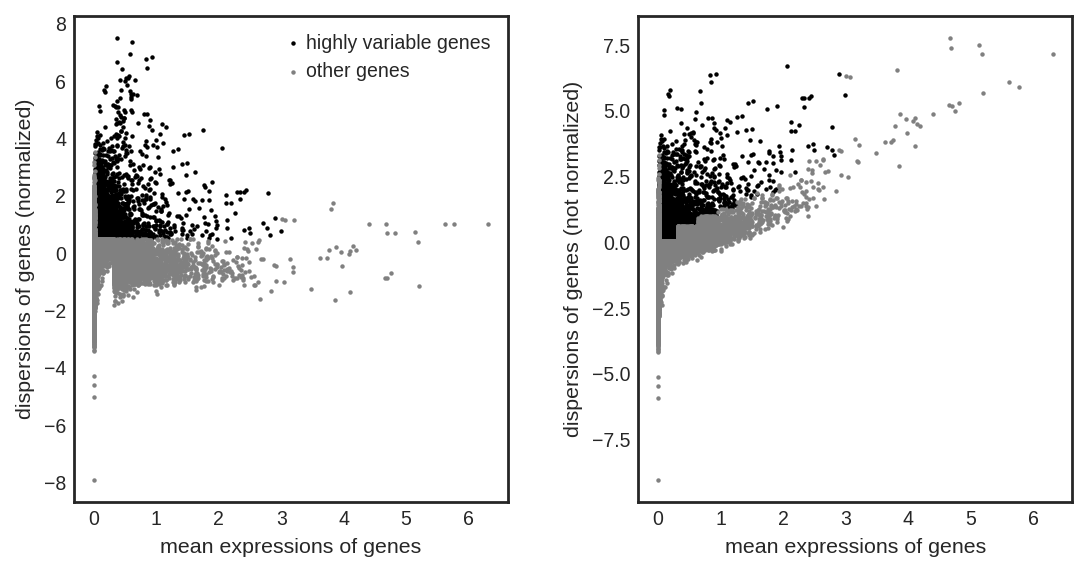

After feature selection of highly variable genes: 2488 cells, 5040 genes
adata scaled with max_value set to 10


In [9]:
# Log1p was already done, because we took the adata.raw of the Segerstolpe2016_processed()
#sc.pp.log1p(adata)
#print('log1p taken of adata')

#adata = adata.copy()
#sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])
#print("'n_counts' and 'percent_mito' regressed out")

sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5, inplace=True)
sc.pl.highly_variable_genes(adata, save='.hvg.png', show=True)
adata = adata[:, adata.var.highly_variable == True]
print('After feature selection of highly variable genes: ' +
             str(adata.shape[0])+' cells, ' + str(adata.shape[1])+' genes')

sc.pp.scale(adata, max_value=10)
print('adata scaled with max_value set to 10')

In [10]:
adata

AnnData object with n_obs × n_vars = 2488 × 5040
    obs: 'Sample Characteristic[organism]', 'Sample Characteristic Ontology Term[organism]', 'Sample Characteristic[individual]', 'Sample Characteristic Ontology Term[individual]', 'Sample Characteristic[sex]', 'Sample Characteristic Ontology Term[sex]', 'Sample Characteristic[age]', 'Sample Characteristic Ontology Term[age]', 'Sample Characteristic[body mass index]', 'Sample Characteristic Ontology Term[body mass index]', 'Sample Characteristic[organism status]', 'Sample Characteristic Ontology Term[organism status]', 'Sample Characteristic[clinical information]', 'Sample Characteristic Ontology Term[clinical information]', 'Sample Characteristic[organism part]', 'Sample Characteristic Ontology Term[organism part]', 'Sample Characteristic[cell type]', 'Sample Characteristic Ontology Term[cell type]', 'Sample Characteristic[disease]', 'Sample Characteristic Ontology Term[disease]', 'Sample Characteristic[biosource provider]', 'Sample Cha

### Feature selection (highly variable genes) for clustering (skipped) ###

In [11]:
#adata = bc.st.highly_variable_genes(adata)

### Regression steps, and output of regressed data (skipped) ###

In [12]:
#adata 

In [13]:
# RMK : AS OF FEB 2020 there is a bug in scanpy regress out if scanpy installed with PIP (see https://github.com/theislab/scanpy/issues/707)
# Before the fix is available, one should coopy the data toprevet it. hence the adata = adata.copy()
#adata = adata.copy()
#adata = bc.st.regress_out(adata, results_folder)

### Batch correction and PCA neighbor analysis and UMAP

The standard workflow uses bbknn as  batch correction method.


Using random_state = 0 for all the following calculations
PCA calculated using svd_solver = 'arpack'. PCA multiplied by -1 to match Seurat output.


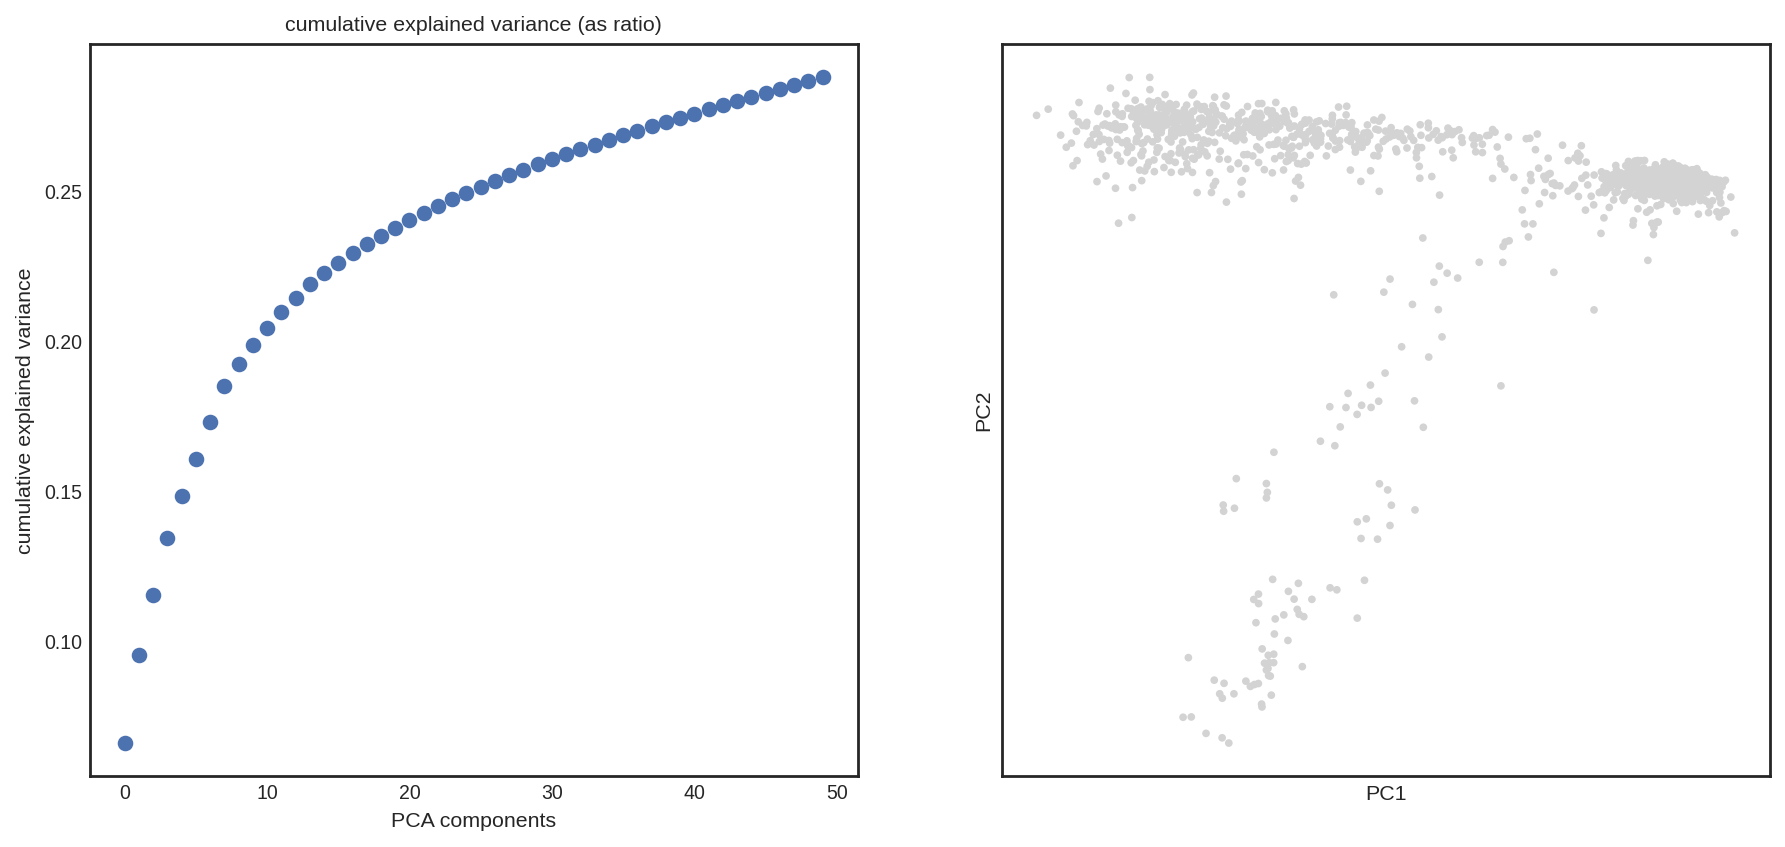

Nearest neighbors calculated with n_neighbors = 10


LOG MESSAGE: Neighborhood analysis completed, and UMAP generated.
LOG MESSAGE: 	 Time for PCA, nearest neighbor calculation and UMAP generation: 9.464s
LOG MESSAGE: Metadata containing 3 PCAs and UMAP coordinates exported successfully to file.
LOG MESSAGE: Time for export: 0.055s


UMAP coordinates calculated.
results successfully written out to 'analysis_metadata.tsv'


In [14]:
if (batch_to_correct != 'None'):
    #save a copy of uncorrected in case we need it for something later
    adata_uncorrected = adata.copy()
    adata.obs['batch'] = adata.obs[batch_to_correct]
    adata = bc.st.pca_neighbors_umap(adata,results_folder, method='bbknn')
else:
    adata = bc.st.pca_neighbors_umap(adata, results_folder)
    

### Clustering ###

leiden clustering performed with a resolution of 1


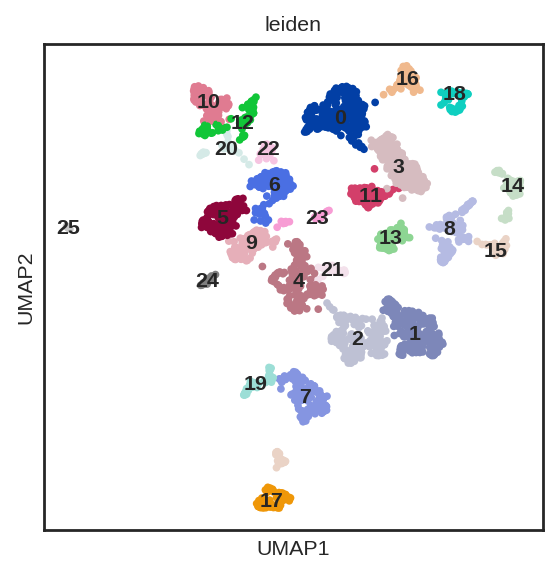

LOG MESSAGE: leidenclustering done. Found 26 clusters.
LOG MESSAGE: 	Time for leiden clustering: 0.411s
LOG MESSAGE: Marker gene detection performed on a per-cluster basis using the method wilcoxon.
LOG MESSAGE: 	Time for marker gene detection: 8.435s


rank genes per cluster calculated using method wilcoxon.
mapping of cells to  leiden exported successfully to cell2labels.tsv
average.gct exported successfully to file
fract_pos.gct exported successfully to file
labelinfo.tsv successfully written out
/pstore/data/bioinfo/users/hatjek/devel/besca_publication_results/pancreas/Segerstolpe2016/analyzed/standard_workflow_besca2.0_without_regress_out/labelings/leiden/WilxRank.gct written out
/pstore/data/bioinfo/users/hatjek/devel/besca_publication_results/pancreas/Segerstolpe2016/analyzed/standard_workflow_besca2.0_without_regress_out/labelings/leiden/WilxRank.pvalues.gct written out


LOG MESSAGE: Cluster level analysis and marker genes exported to file.
LOG MESSAGE: 	Time for export of cluster level analysis: 5.705s


/pstore/data/bioinfo/users/hatjek/devel/besca_publication_results/pancreas/Segerstolpe2016/analyzed/standard_workflow_besca2.0_without_regress_out/labelings/leiden/WilxRank.logFC.gct written out


In [15]:
# leiden clustering is the default 
adata = bc.st.clustering(adata, results_folder)

In [16]:
# everything that was done so far goes to the .h5ad file for later use
adata.write(results_file)
print(results_file)

/pstore/data/bioinfo/users/hatjek/devel/besca_publication_results/pancreas/Segerstolpe2016/analyzed/standard_workflow_besca2.0_without_regress_out/standard_workflow_besca2.0_without_regress_out.h5ad


In [17]:
adata.obs_keys

<bound method AnnData.obs_keys of AnnData object with n_obs × n_vars = 2488 × 5040
    obs: 'Sample Characteristic[organism]', 'Sample Characteristic Ontology Term[organism]', 'Sample Characteristic[individual]', 'Sample Characteristic Ontology Term[individual]', 'Sample Characteristic[sex]', 'Sample Characteristic Ontology Term[sex]', 'Sample Characteristic[age]', 'Sample Characteristic Ontology Term[age]', 'Sample Characteristic[body mass index]', 'Sample Characteristic Ontology Term[body mass index]', 'Sample Characteristic[organism status]', 'Sample Characteristic Ontology Term[organism status]', 'Sample Characteristic[clinical information]', 'Sample Characteristic Ontology Term[clinical information]', 'Sample Characteristic[organism part]', 'Sample Characteristic Ontology Term[organism part]', 'Sample Characteristic[cell type]', 'Sample Characteristic Ontology Term[cell type]', 'Sample Characteristic[disease]', 'Sample Characteristic Ontology Term[disease]', 'Sample Characteristic

LOG MESSAGE: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
LOG MESSAGE: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
LOG MESSAGE: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
LOG MES

LOG MESSAGE: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
LOG MESSAGE: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
LOG MESSAGE: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
LOG MES

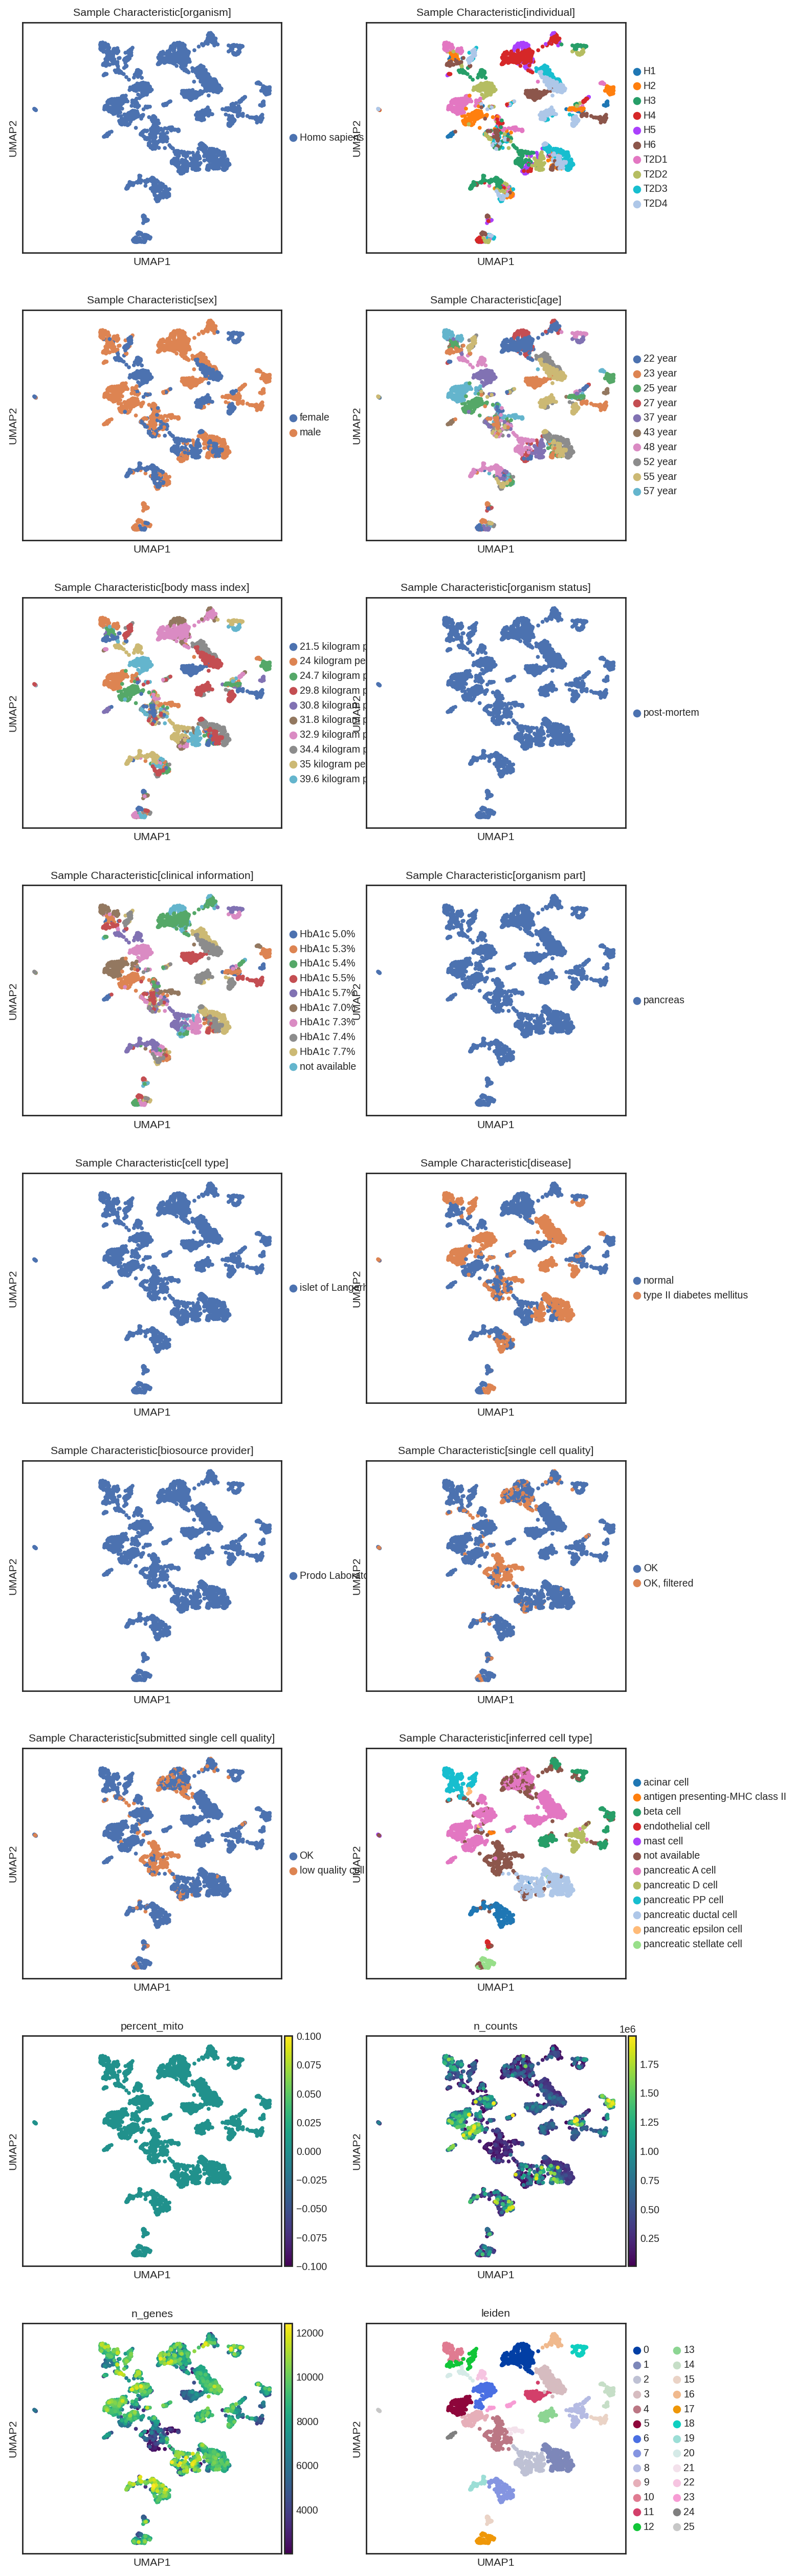

In [18]:
sc.pl.umap( adata, color=['Sample Characteristic[organism]',  'Sample Characteristic[individual]', 
                         'Sample Characteristic[sex]',
                          'Sample Characteristic[age]', 'Sample Characteristic[body mass index]',
                          'Sample Characteristic[organism status]', 
                          'Sample Characteristic[clinical information]', 
                          'Sample Characteristic[organism part]', 
                           'Sample Characteristic[cell type]',  'Sample Characteristic[disease]', 
                         'Sample Characteristic[biosource provider]',  'Sample Characteristic[single cell quality]', 
                        'Sample Characteristic[submitted single cell quality]',
                           'Sample Characteristic[inferred cell type]', 
                        #'Factor Value[disease]', 
                          'percent_mito', 'n_counts', 
                          'n_genes', 'leiden'], color_map = 'viridis', ncols=2)


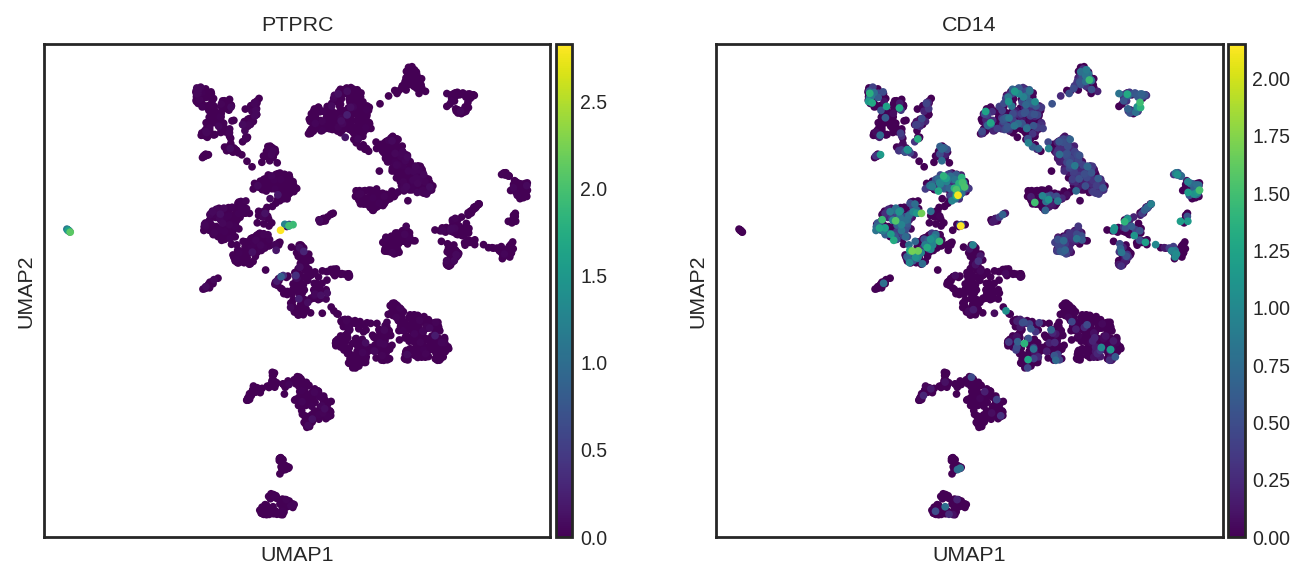

In [19]:
sc.pl.umap( adata, color=['PTPRC', 'CD14'], color_map = 'viridis')

### Additional Labeling ###

(if specified) based on external annotation in "metadata.tsv"  the additional labeling will be exported to file and the fract_pos.gct and average.gct files generated

In [20]:
if (labeling_to_use != 'None'):
    adata = bc.st.additional_labeling(adata, labeling_to_use, labeling_name, labeling_description, labeling_author, results_folder)

### Complete log-file

In [21]:
logging.info('Entire workflow completed.')
logging.info('\tTime for entire workflow: '+str(round(time.time()-start0, 3))+'s')

LOG MESSAGE: Entire workflow completed.
LOG MESSAGE: 	Time for entire workflow: 35.924s


### Write QC Report

### Comparison to original standard workflow

In [22]:
adata

AnnData object with n_obs × n_vars = 2488 × 5040
    obs: 'Sample Characteristic[organism]', 'Sample Characteristic Ontology Term[organism]', 'Sample Characteristic[individual]', 'Sample Characteristic Ontology Term[individual]', 'Sample Characteristic[sex]', 'Sample Characteristic Ontology Term[sex]', 'Sample Characteristic[age]', 'Sample Characteristic Ontology Term[age]', 'Sample Characteristic[body mass index]', 'Sample Characteristic Ontology Term[body mass index]', 'Sample Characteristic[organism status]', 'Sample Characteristic Ontology Term[organism status]', 'Sample Characteristic[clinical information]', 'Sample Characteristic Ontology Term[clinical information]', 'Sample Characteristic[organism part]', 'Sample Characteristic Ontology Term[organism part]', 'Sample Characteristic[cell type]', 'Sample Characteristic Ontology Term[cell type]', 'Sample Characteristic[disease]', 'Sample Characteristic Ontology Term[disease]', 'Sample Characteristic[biosource provider]', 'Sample Cha

In [23]:
# Read the results file from the original standard workflow
adata_std = bc.datasets.Segerstolpe2016_processed()
adata_std

AnnData object with n_obs × n_vars = 2488 × 5040
    obs: 'Sample Characteristic[organism]', 'Sample Characteristic Ontology Term[organism]', 'Sample Characteristic[individual]', 'Sample Characteristic Ontology Term[individual]', 'Sample Characteristic[sex]', 'Sample Characteristic Ontology Term[sex]', 'Sample Characteristic[age]', 'Sample Characteristic Ontology Term[age]', 'Sample Characteristic[body mass index]', 'Sample Characteristic Ontology Term[body mass index]', 'Sample Characteristic[organism status]', 'Sample Characteristic Ontology Term[organism status]', 'Sample Characteristic[clinical information]', 'Sample Characteristic Ontology Term[clinical information]', 'Sample Characteristic[organism part]', 'Sample Characteristic Ontology Term[organism part]', 'Sample Characteristic[cell type]', 'Sample Characteristic Ontology Term[cell type]', 'Sample Characteristic[disease]', 'Sample Characteristic Ontology Term[disease]', 'Sample Characteristic[biosource provider]', 'Sample Cha

HVGs regress out before feature selection: 5040
HVGs feature selection before regress out: 5040
HVGs intersection: 5040


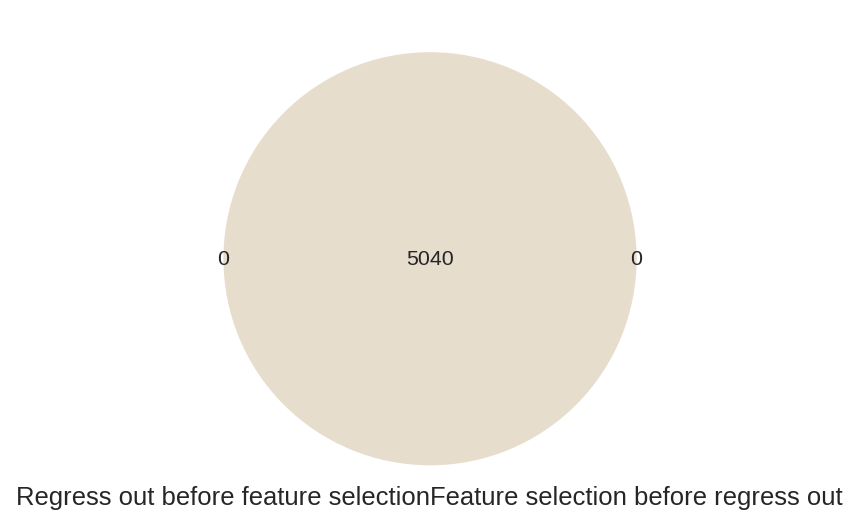

In [24]:
# Intersection of highly variable genes (HVG) and Venn diagram

hvg_adata = adata.var_names
hvg_adata_std = adata_std.var_names
hvg_intersection = list(set(hvg_adata) & set(hvg_adata_std))

print('HVGs regress out before feature selection: ' + str(len(hvg_adata)))
print('HVGs feature selection before regress out: ' + str(len(hvg_adata_std)))
print('HVGs intersection: ' + str(len(hvg_intersection)))

from matplotlib_venn import venn2
venn2(
    subsets = (len(hvg_adata)-len(hvg_intersection), len(hvg_adata_std)-len(hvg_intersection), len(hvg_intersection)), 
    set_labels = ('Regress out before feature selection', 'Feature selection before regress out')
)

In [25]:
# Add labelings from original workflow for comparison
adata.obs = adata.obs.join(adata_std.obs['leiden'], rsuffix='_std')

acc: 0.69
f1: 0.68
ami: 0.97
ari: 0.97
silhouette leiden_std: 0.49
silhouette leiden: 0.5
pair confusion matrix:
         0       1
0  5833634    8634
1    10886  334502


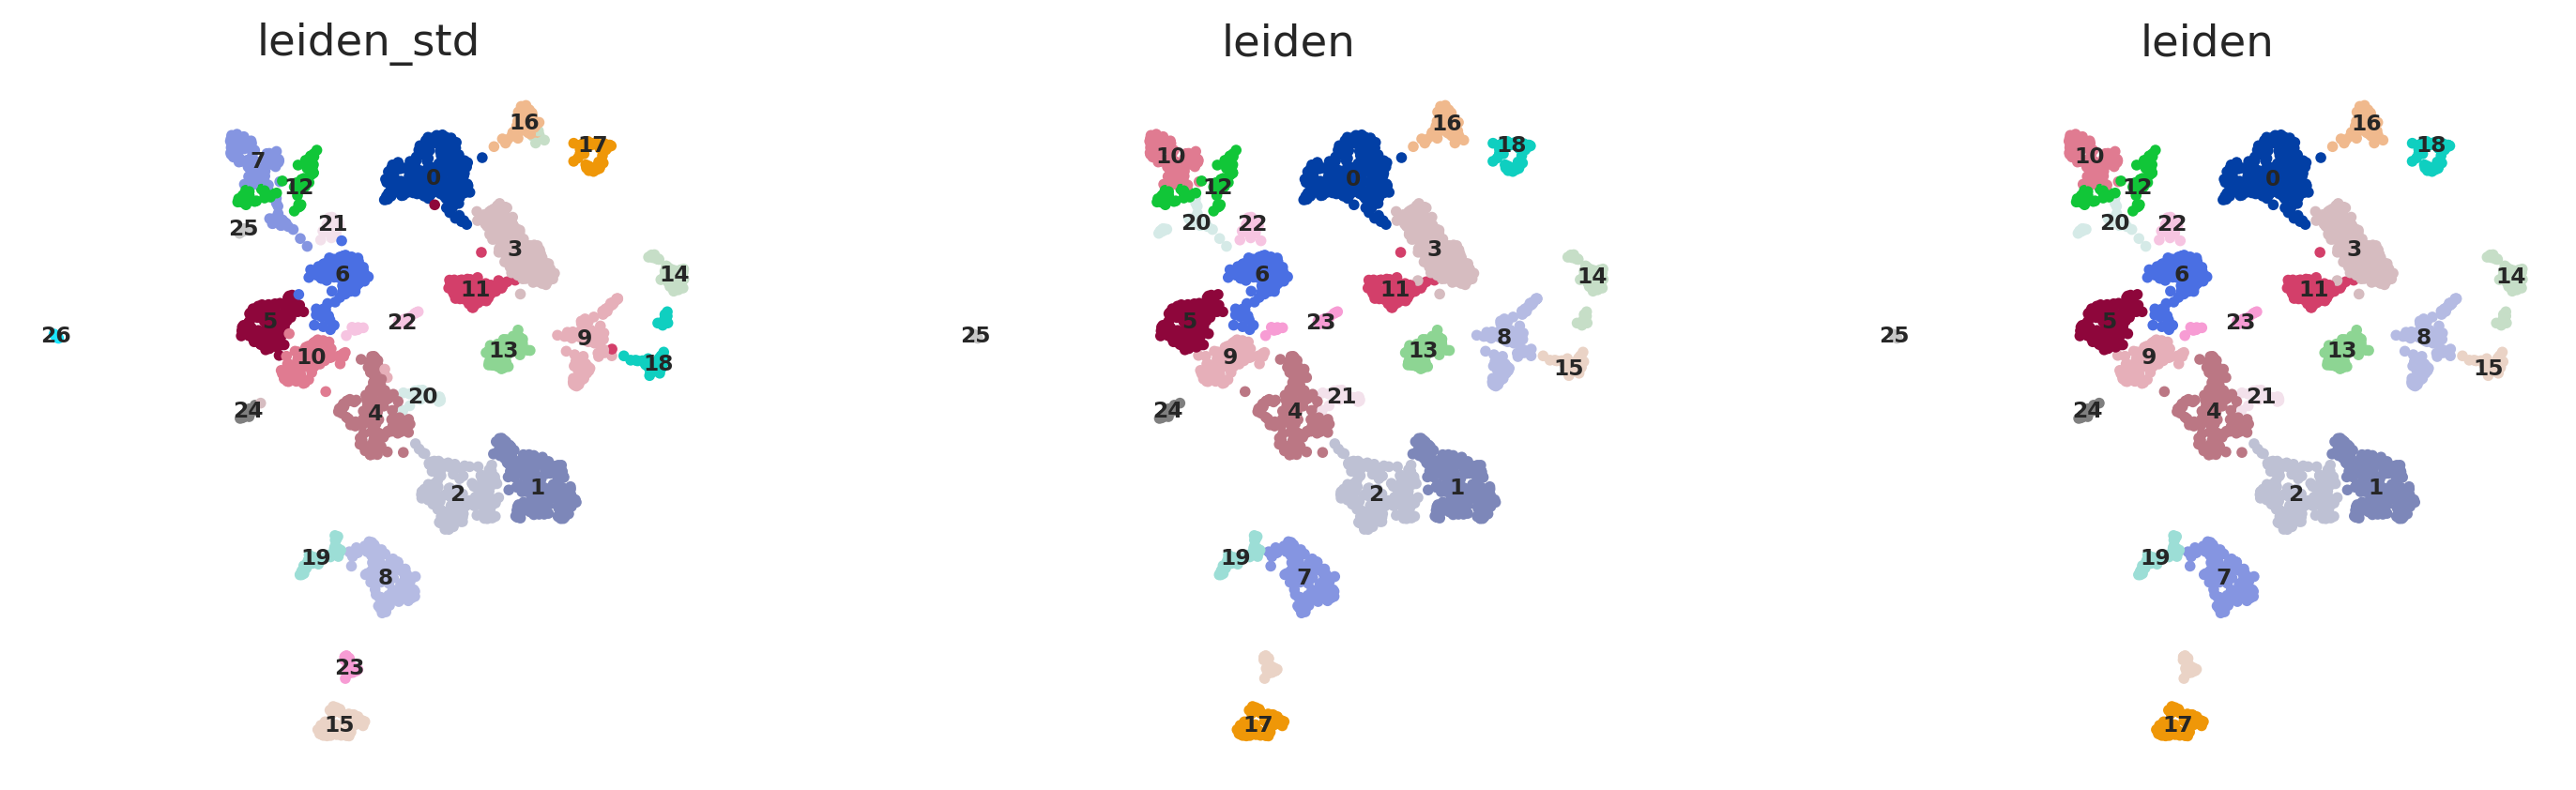

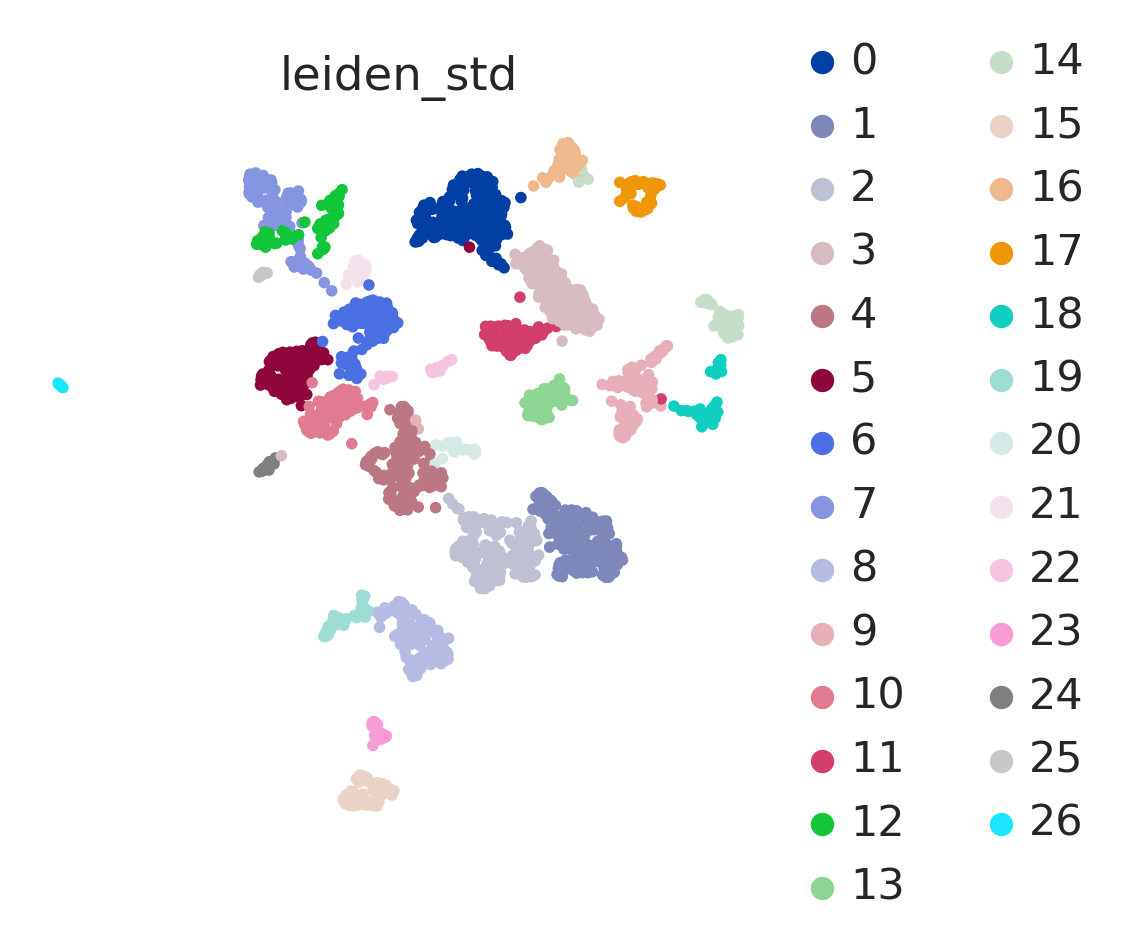

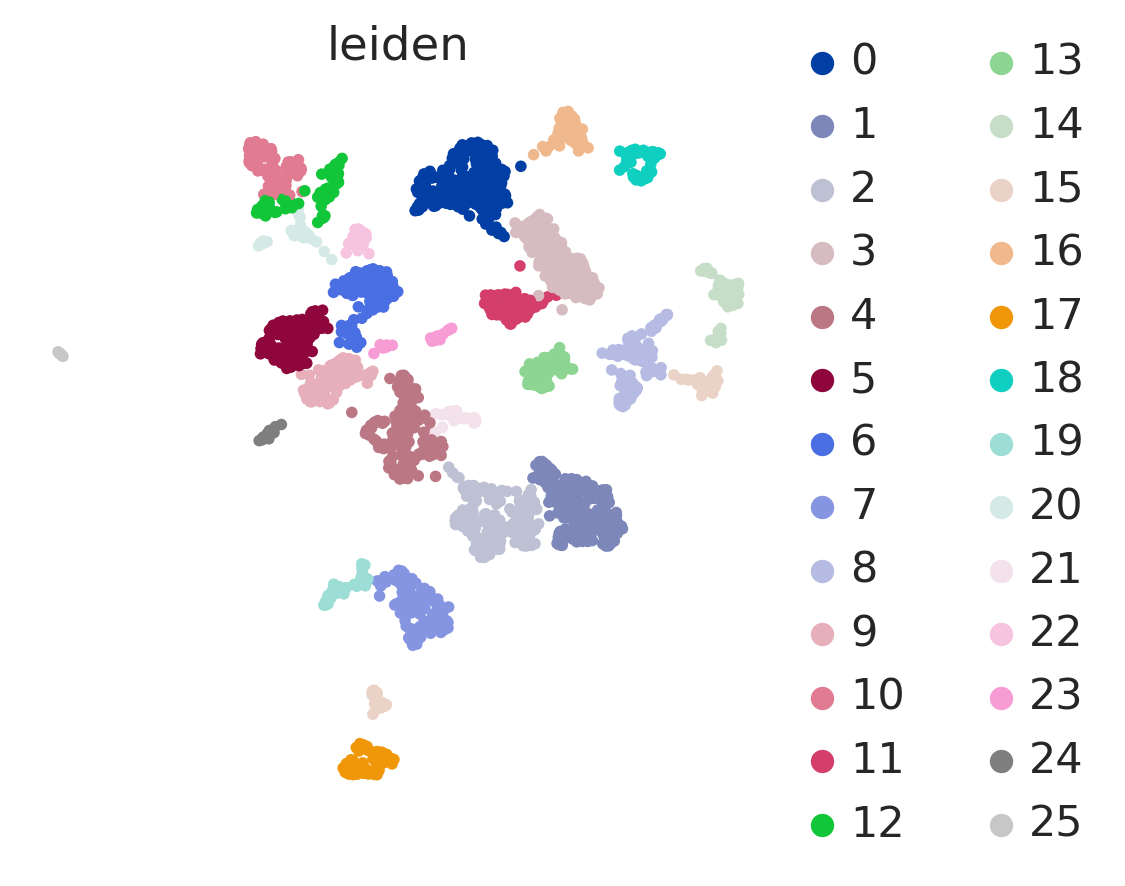

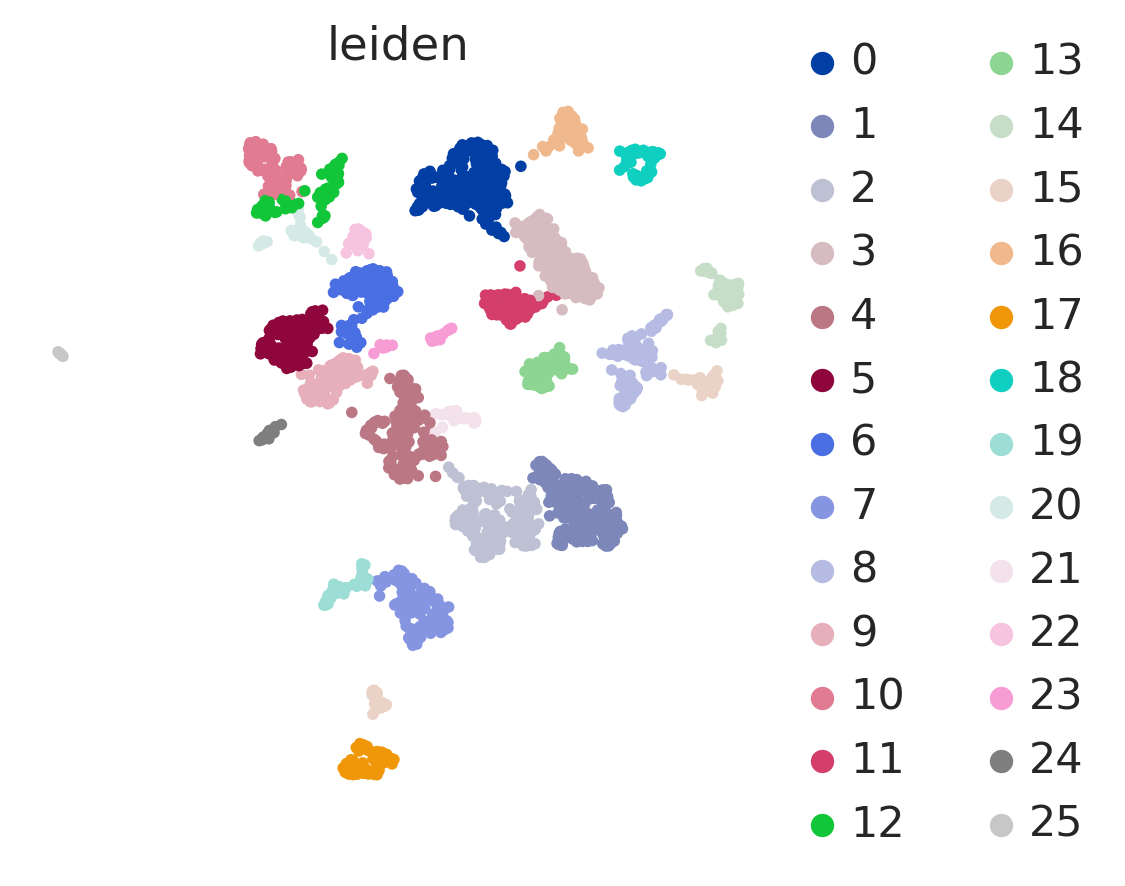

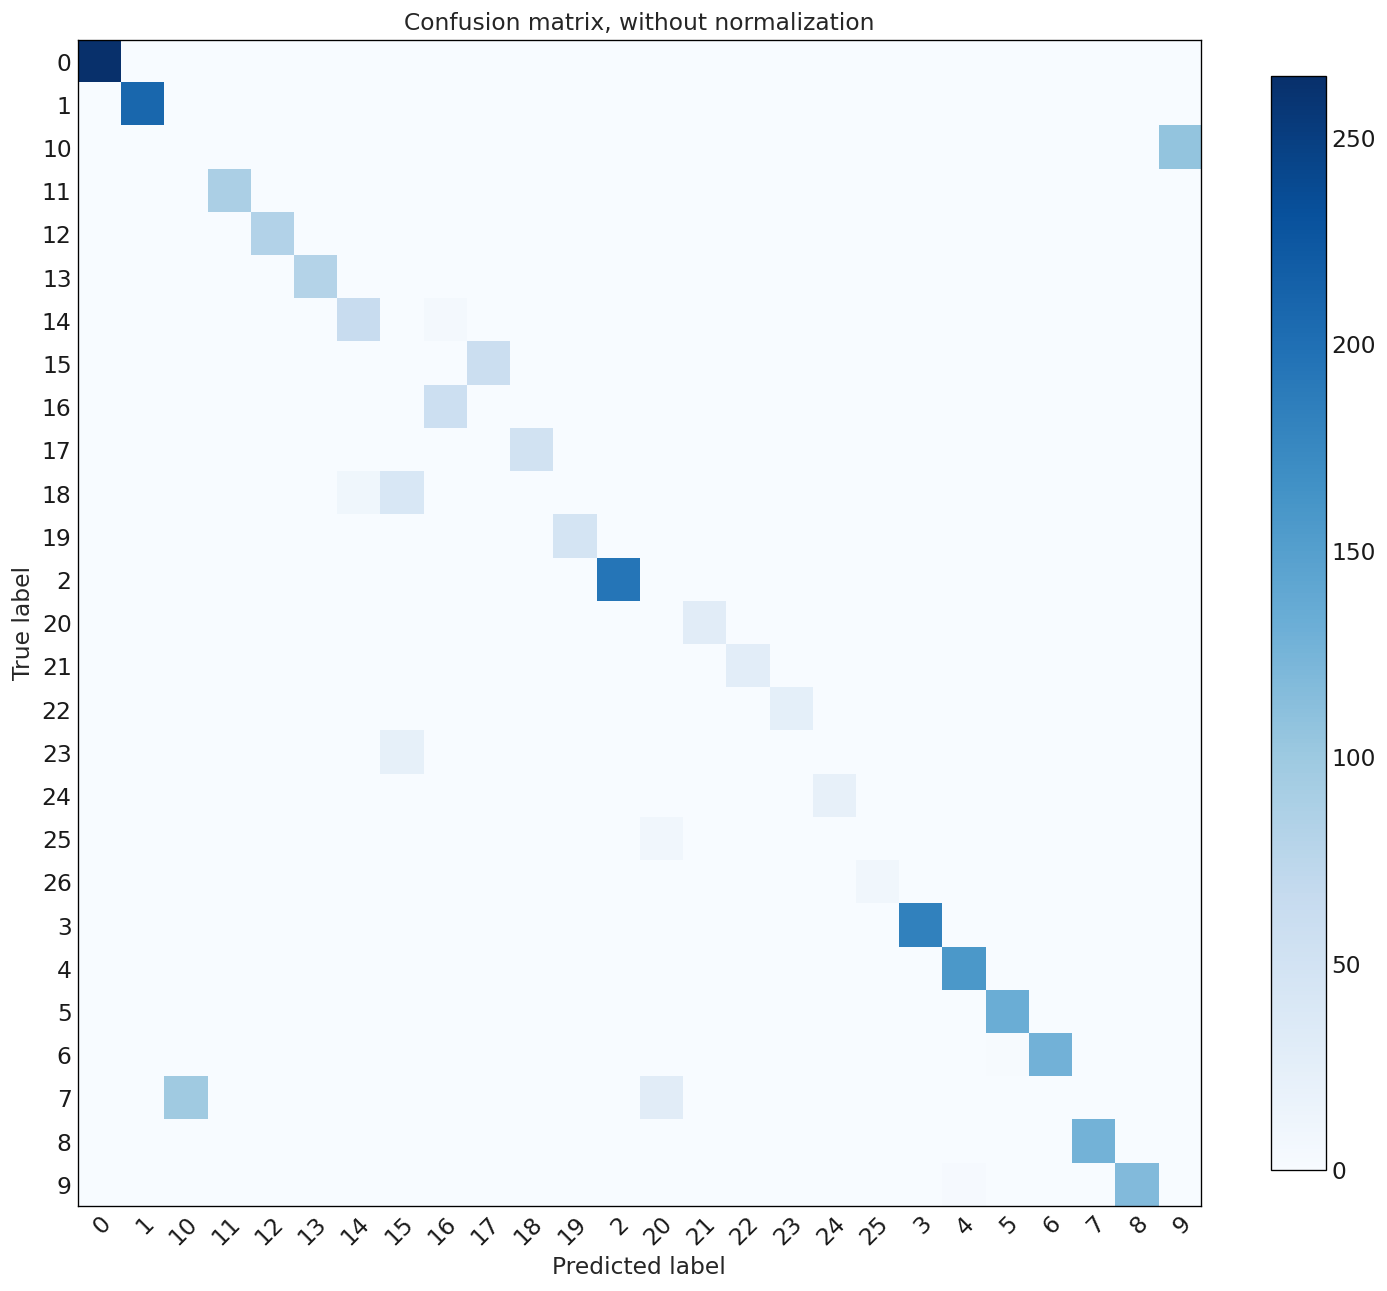

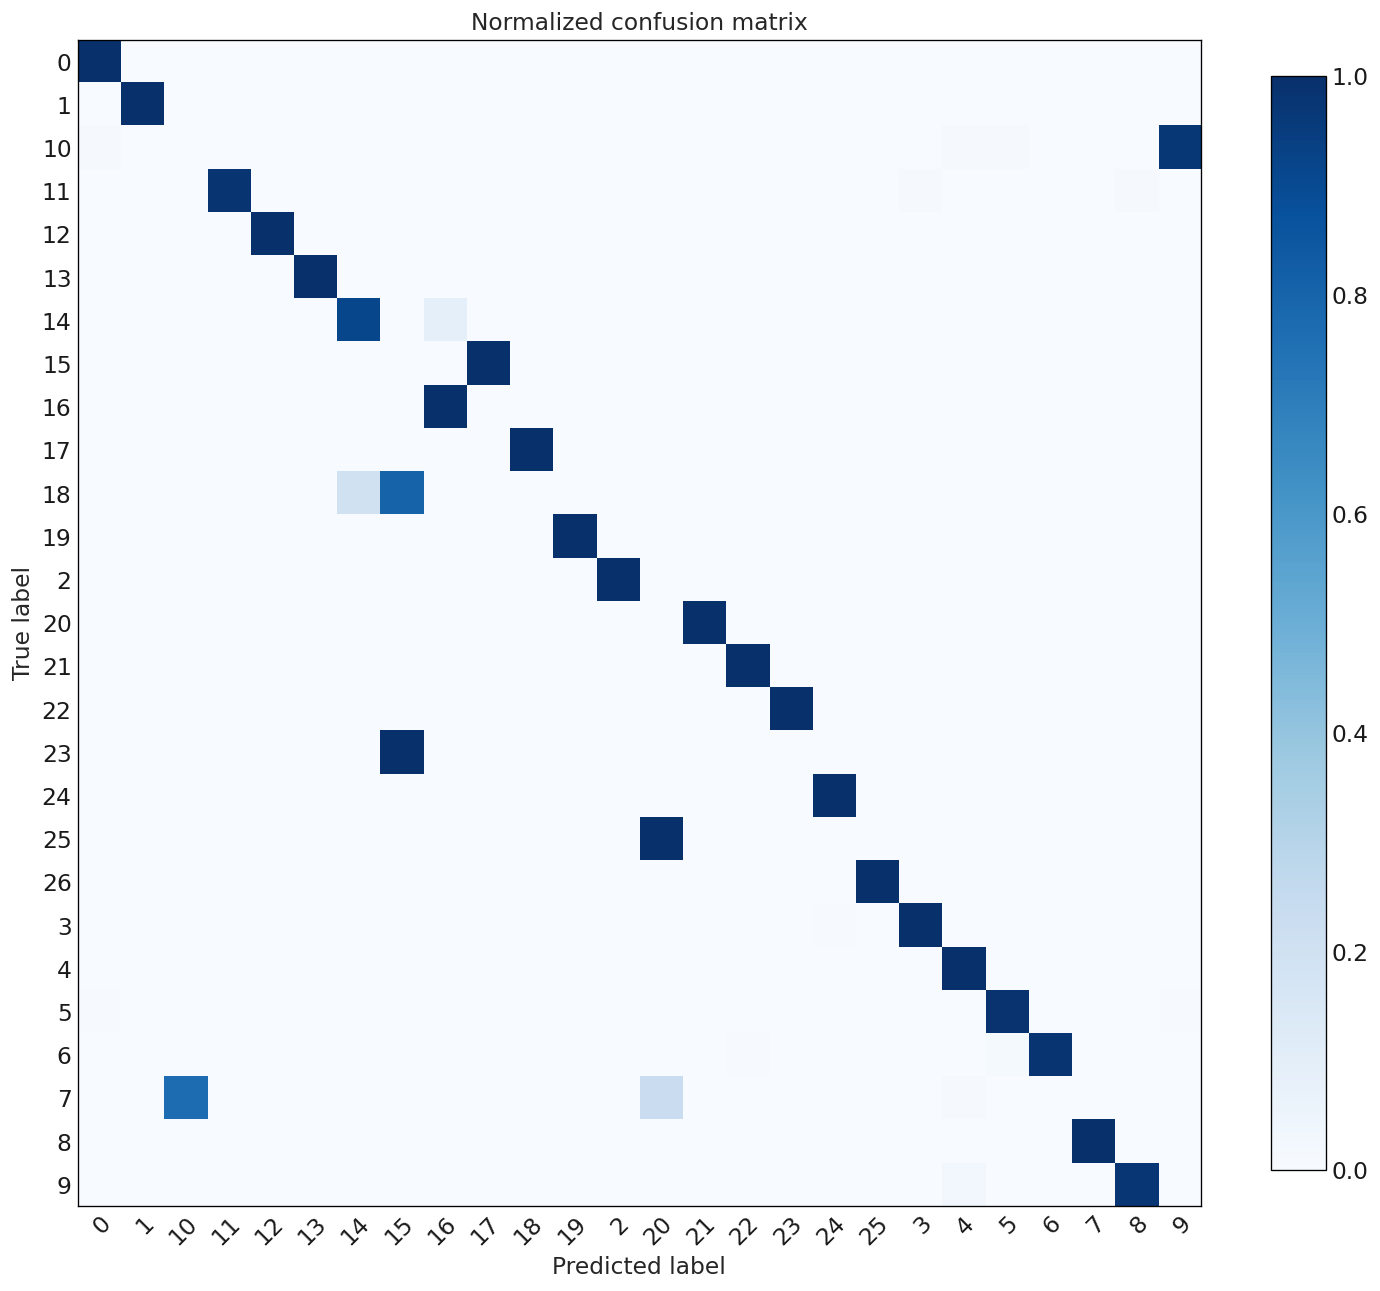

In [26]:
bc.tl.report(adata_pred=adata, celltype='leiden_std', method='without_regress_out', analysis_name=analysis_name,
                        test_dataset='adata_new', name_prediction='leiden', name_report='compare_leiden', use_raw=False,
                        remove_nonshared=False, clustering='leiden', asymmetric_matrix=True, delimiter='\t', verbose=True)

In [27]:
# Assess the original workflow and add new clustering for comparison
adata_std.obs = adata_std.obs.join(adata.obs['leiden'], rsuffix='_new')

acc: 0.69
f1: 0.69
ami: 0.97
ari: 0.97
silhouette leiden_new: 0.47
silhouette leiden: 0.5
pair confusion matrix:
         0       1
0  5833634   10886
1     8634  334502


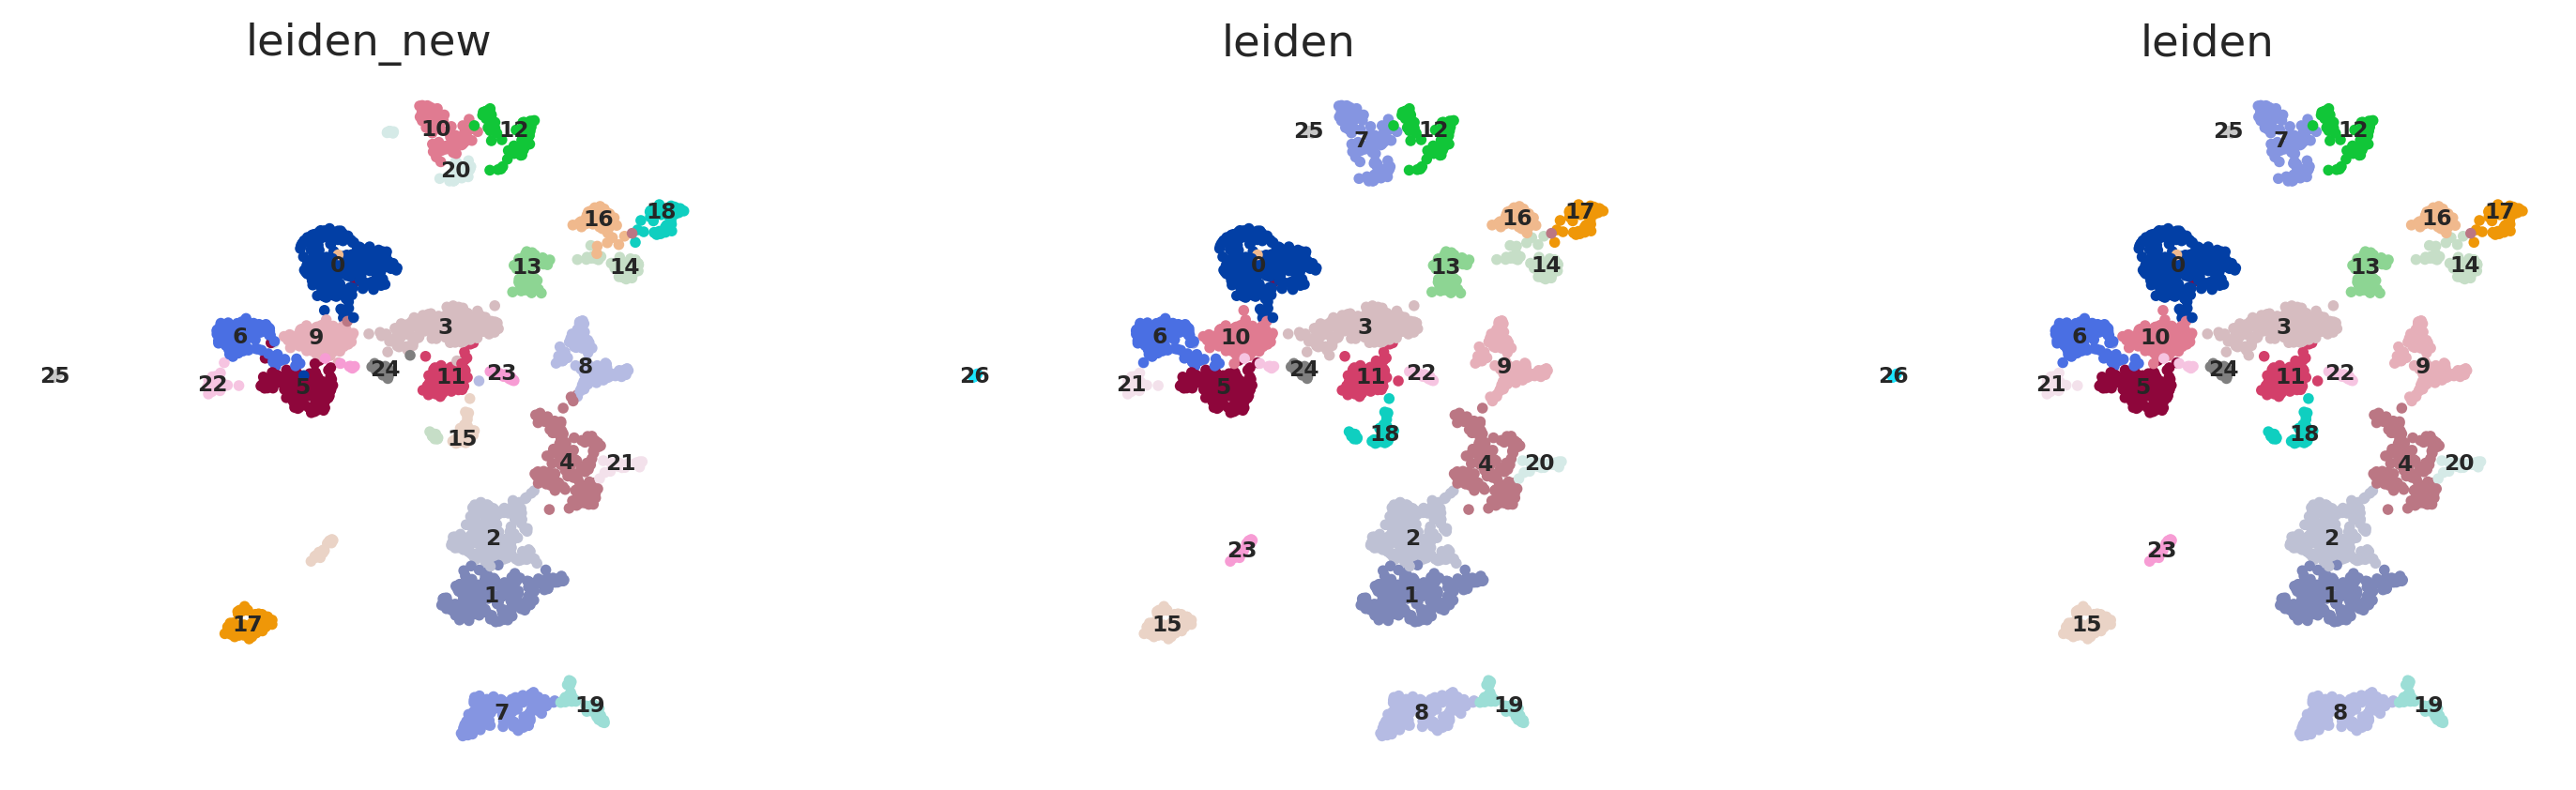

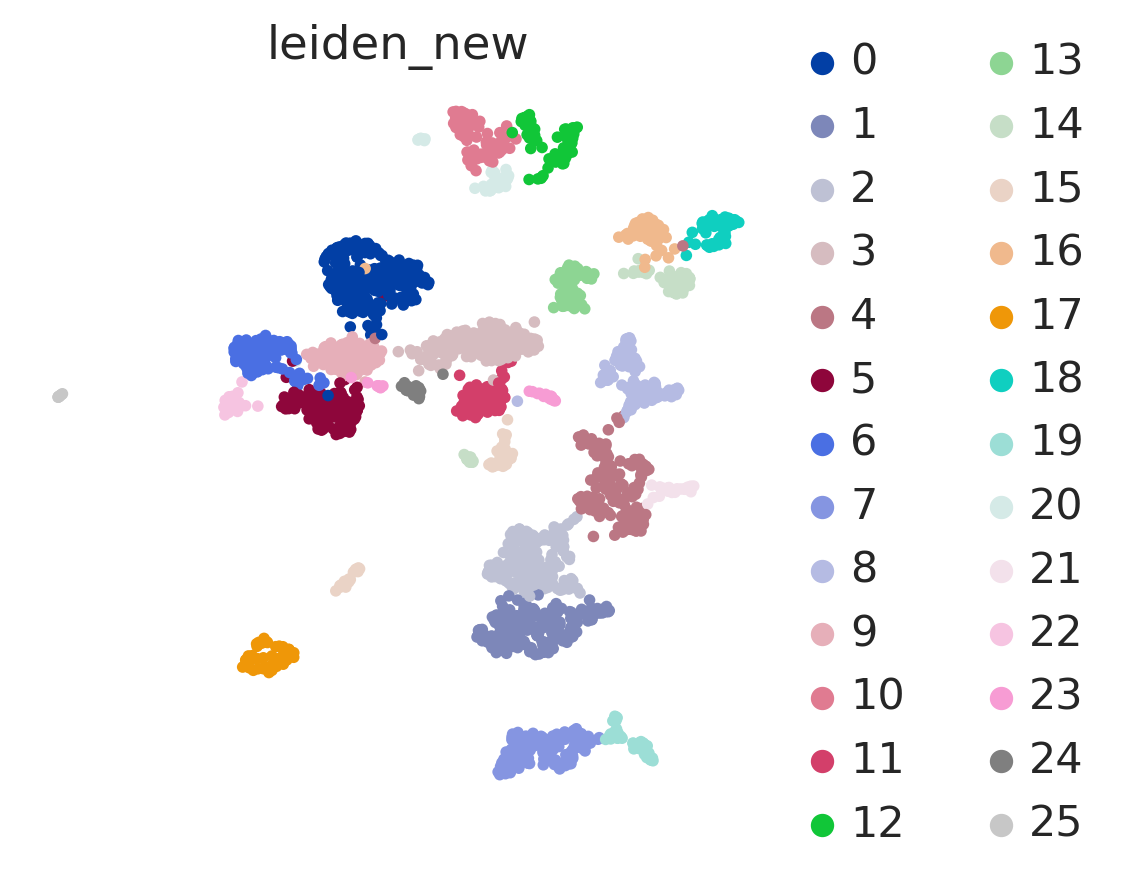

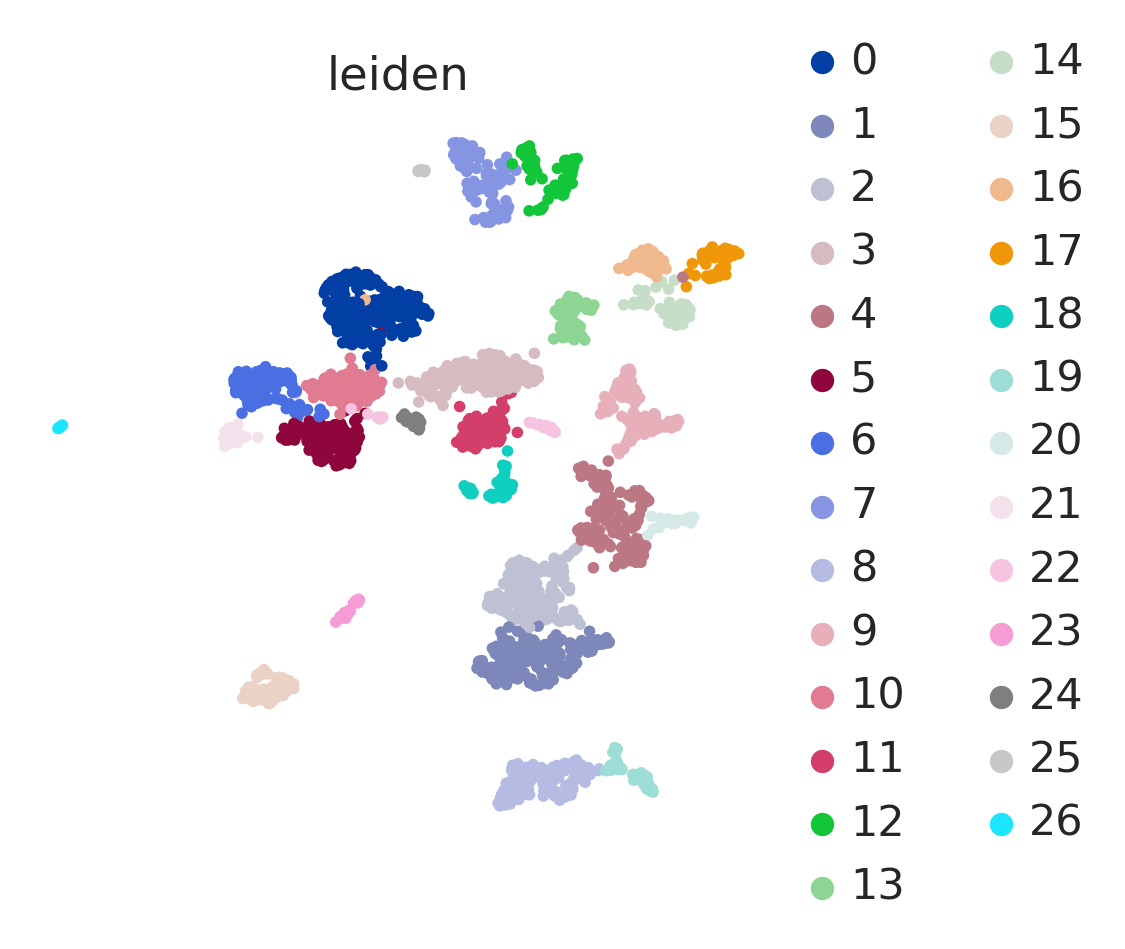

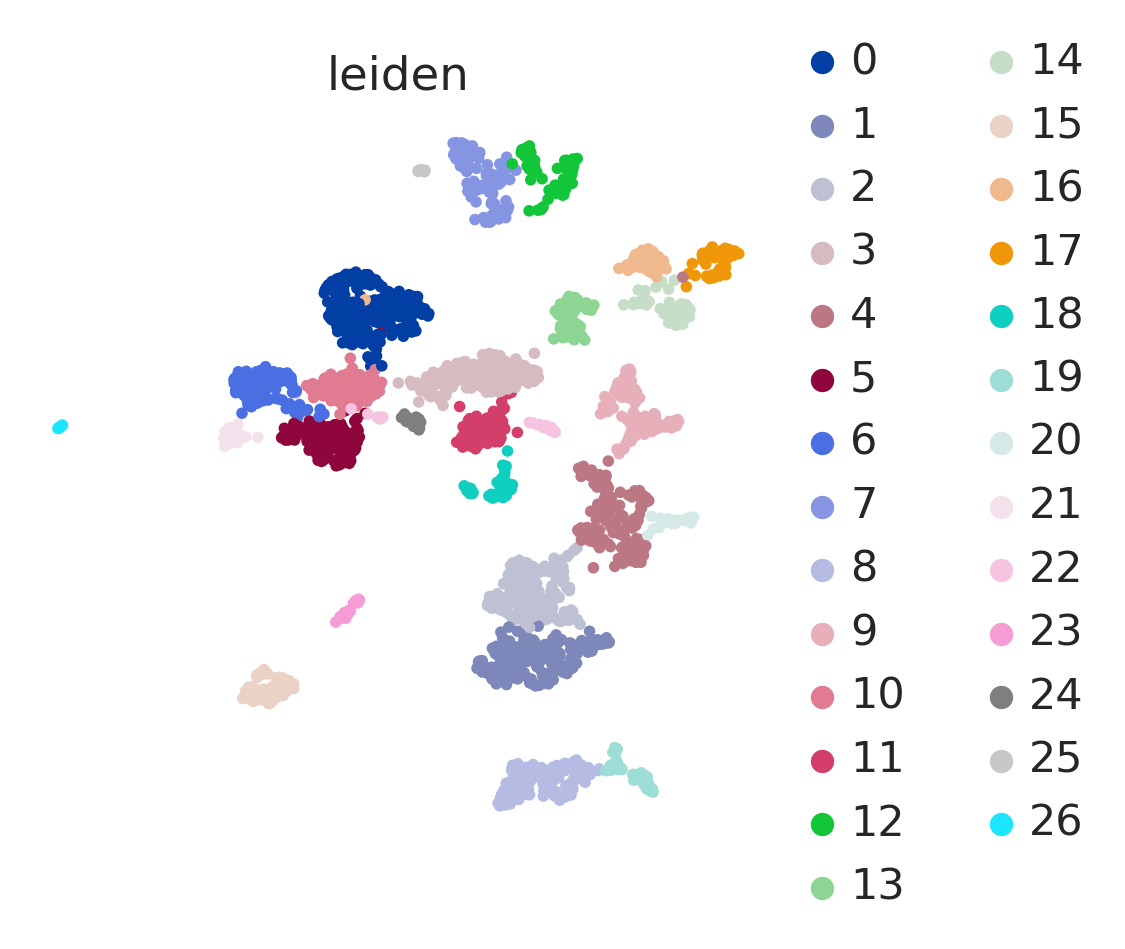

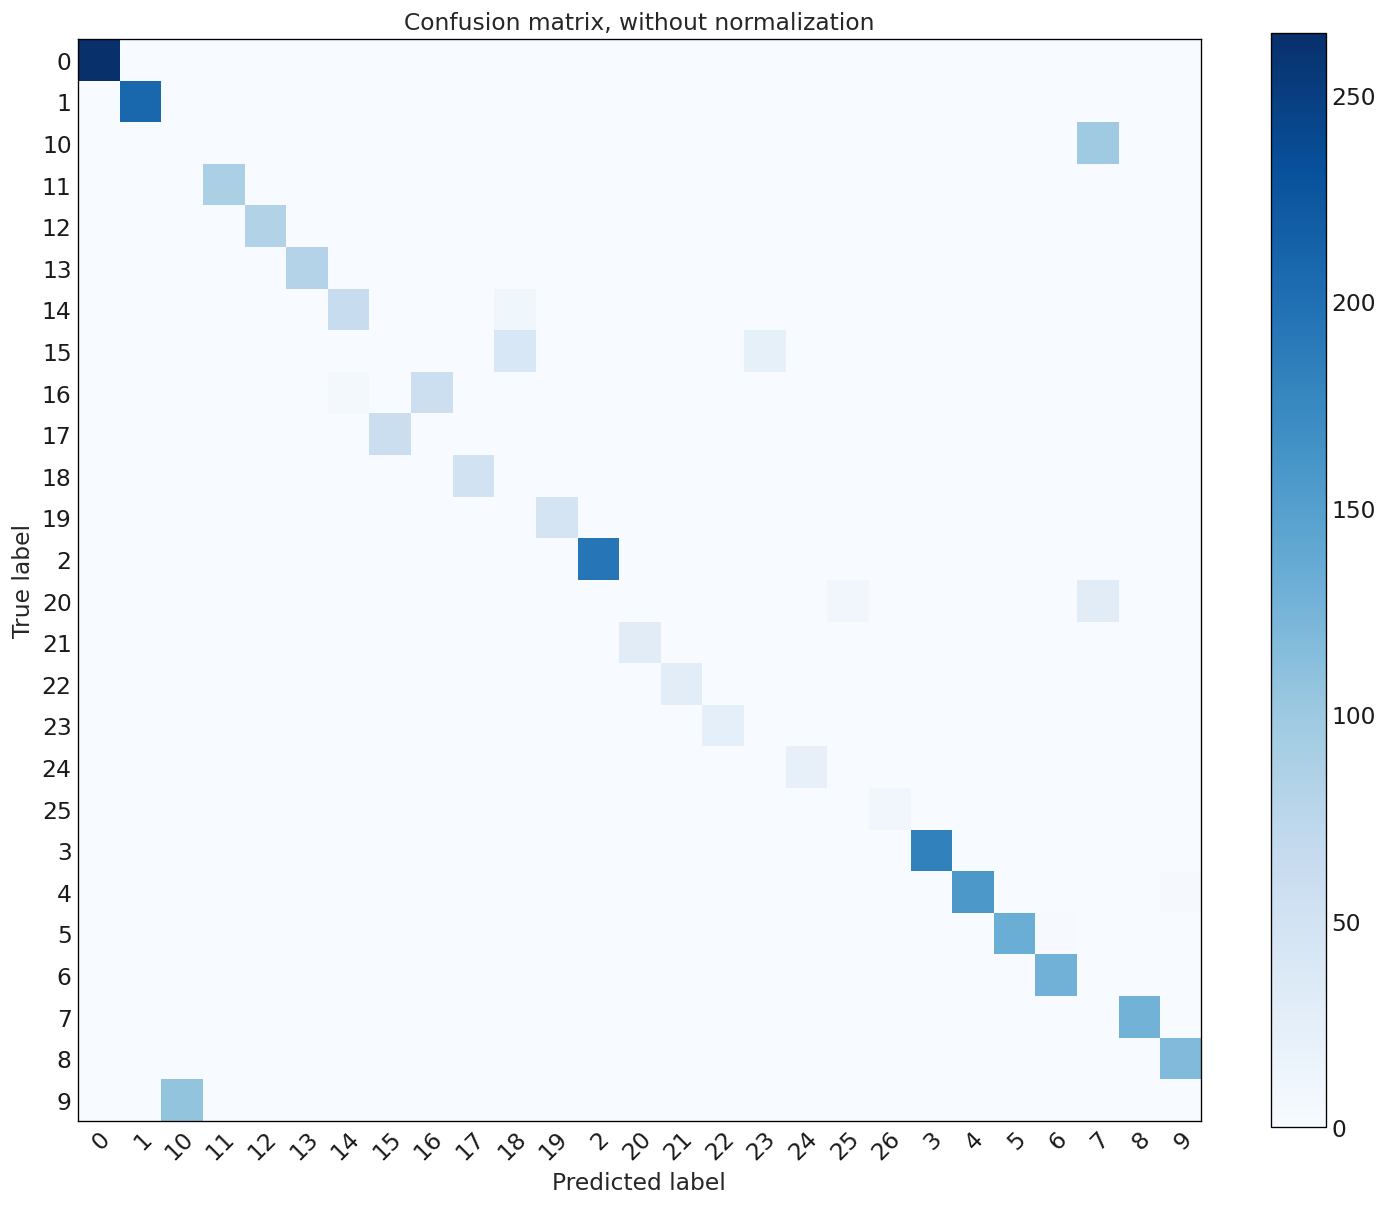

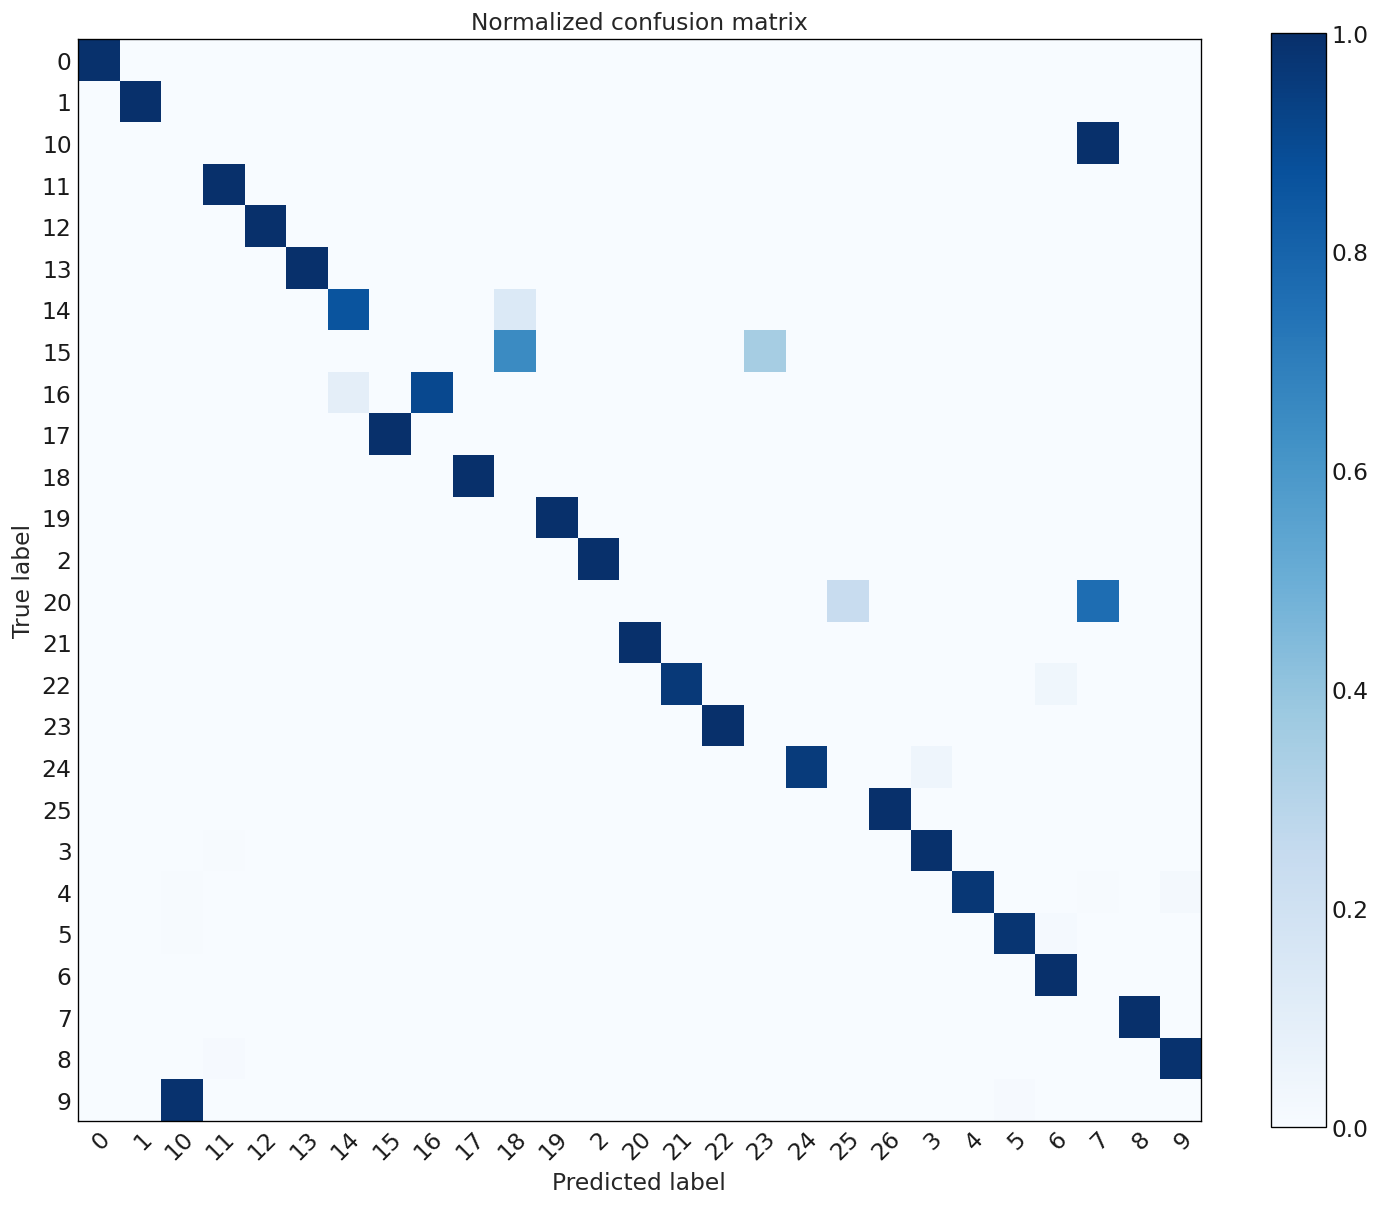

In [28]:
bc.tl.report(adata_pred=adata_std, celltype='leiden_new', method='without_regress_out', analysis_name='standard_workflow_besca2.0',
                        test_dataset='adata_std', name_prediction='leiden', name_report='compare_leiden', use_raw=False,
                        remove_nonshared=False, clustering='leiden', asymmetric_matrix=True, delimiter='\t', verbose=True)

In [29]:
# Read the results file from the regress out before hvg selection workflow
adata_reg_before_hvg = sc.read(os.path.join(results_folder, '..', 'standard_workflow_besca2.0_regress_out_before_hvg_selection/standard_workflow_besca2.0_regress_out_before_hvg_selection.h5ad'))
adata_reg_before_hvg

AnnData object with n_obs × n_vars = 2488 × 3011
    obs: 'Sample Characteristic[organism]', 'Sample Characteristic Ontology Term[organism]', 'Sample Characteristic[individual]', 'Sample Characteristic Ontology Term[individual]', 'Sample Characteristic[sex]', 'Sample Characteristic Ontology Term[sex]', 'Sample Characteristic[age]', 'Sample Characteristic Ontology Term[age]', 'Sample Characteristic[body mass index]', 'Sample Characteristic Ontology Term[body mass index]', 'Sample Characteristic[organism status]', 'Sample Characteristic Ontology Term[organism status]', 'Sample Characteristic[clinical information]', 'Sample Characteristic Ontology Term[clinical information]', 'Sample Characteristic[organism part]', 'Sample Characteristic Ontology Term[organism part]', 'Sample Characteristic[cell type]', 'Sample Characteristic Ontology Term[cell type]', 'Sample Characteristic[disease]', 'Sample Characteristic Ontology Term[disease]', 'Sample Characteristic[biosource provider]', 'Sample Cha

In [30]:
# Add clustering from the regress out before hvg selection workflow
adata.obs = adata.obs.join(adata_reg_before_hvg.obs['leiden'], rsuffix='_reg_before_hvg')

acc: 0.38
f1: 0.38
ami: 0.92
ari: 0.87
silhouette leiden_reg_before_hvg: 0.41
silhouette leiden: 0.5
pair confusion matrix:
         0       1
0  5798976   36630
1    45544  306506


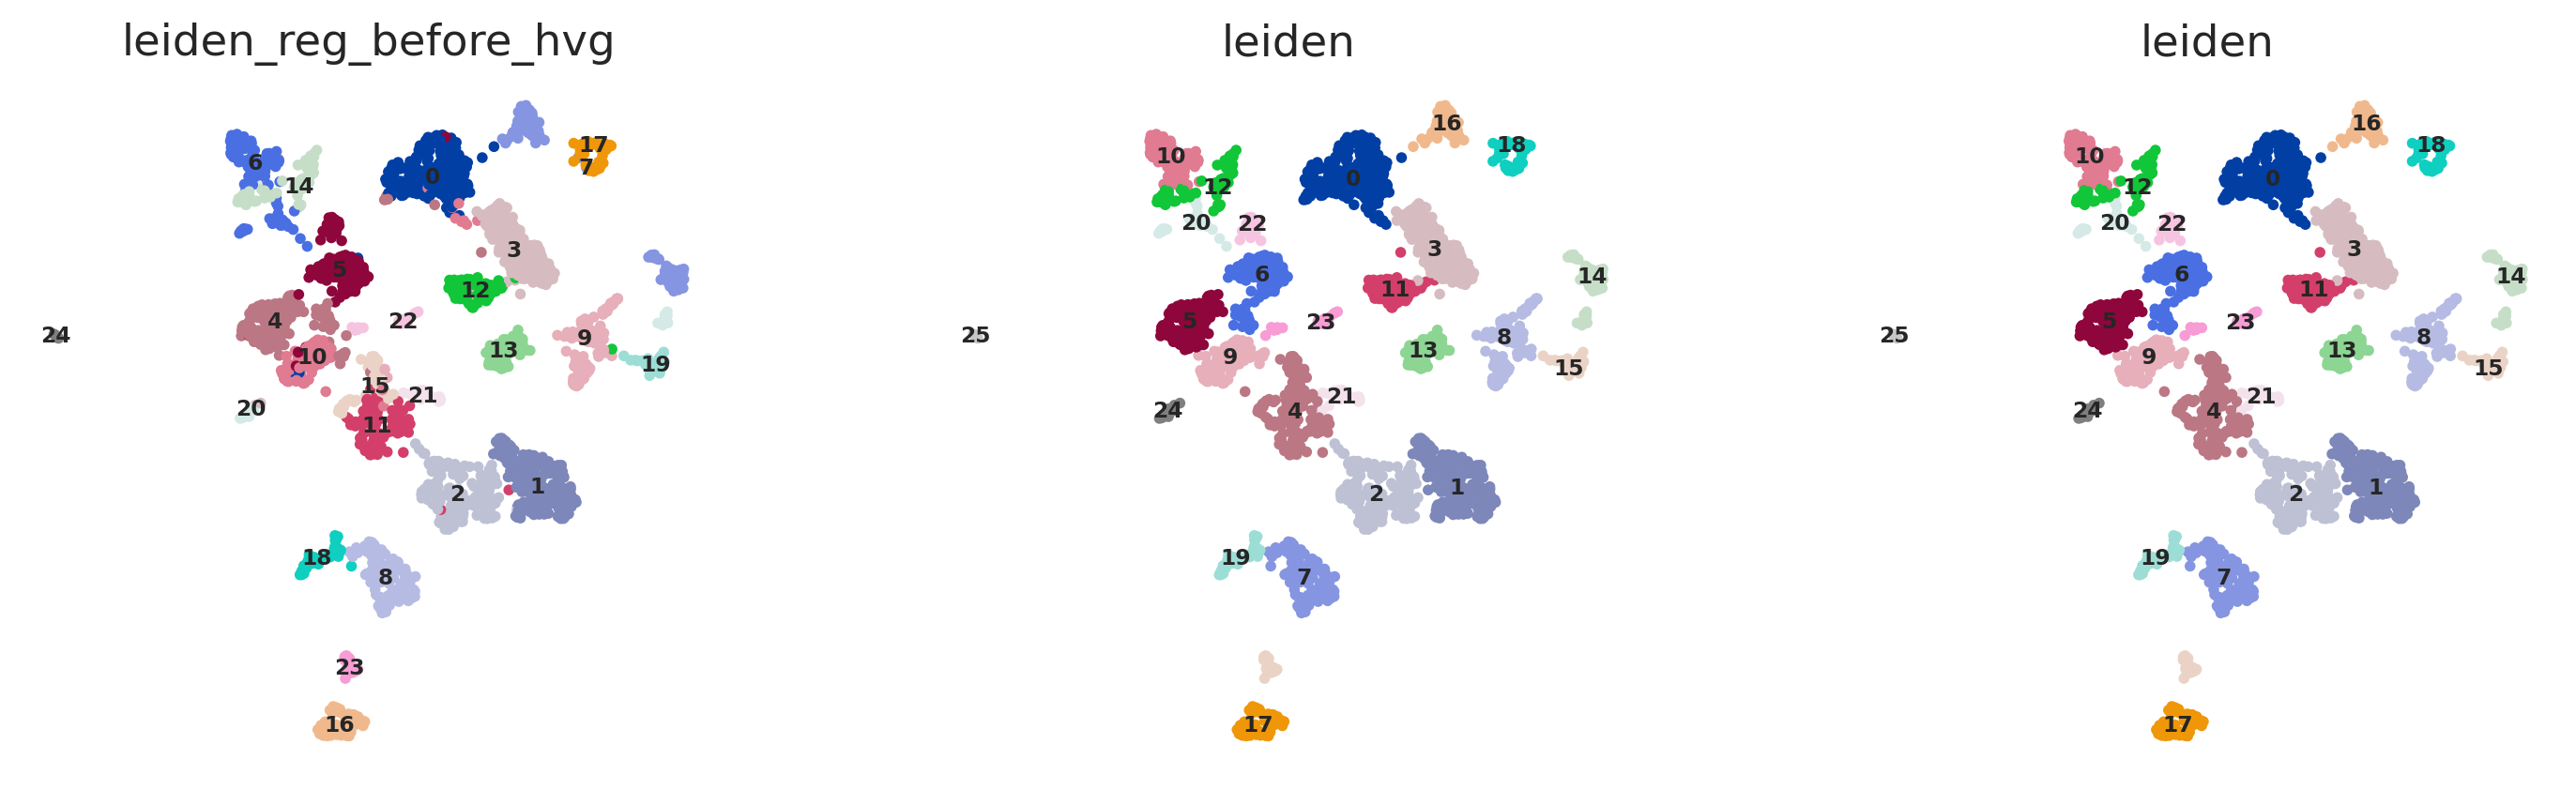

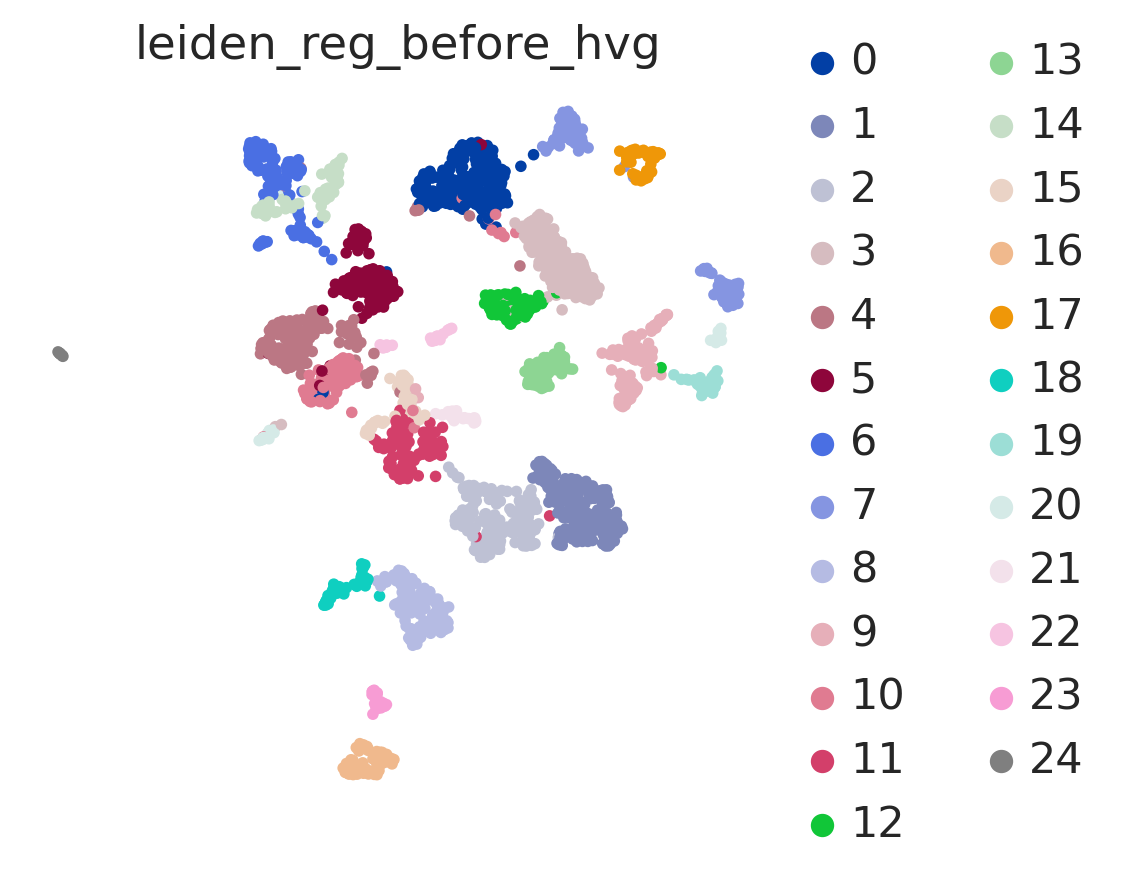

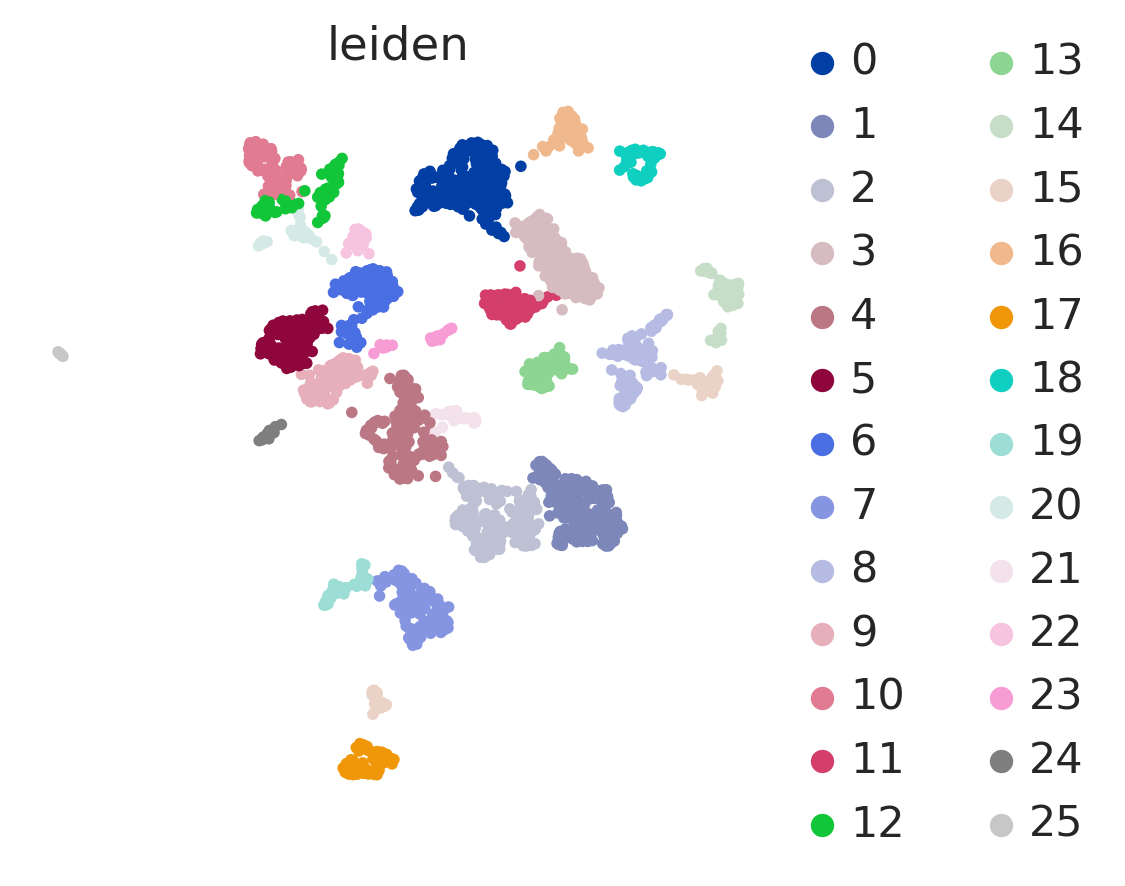

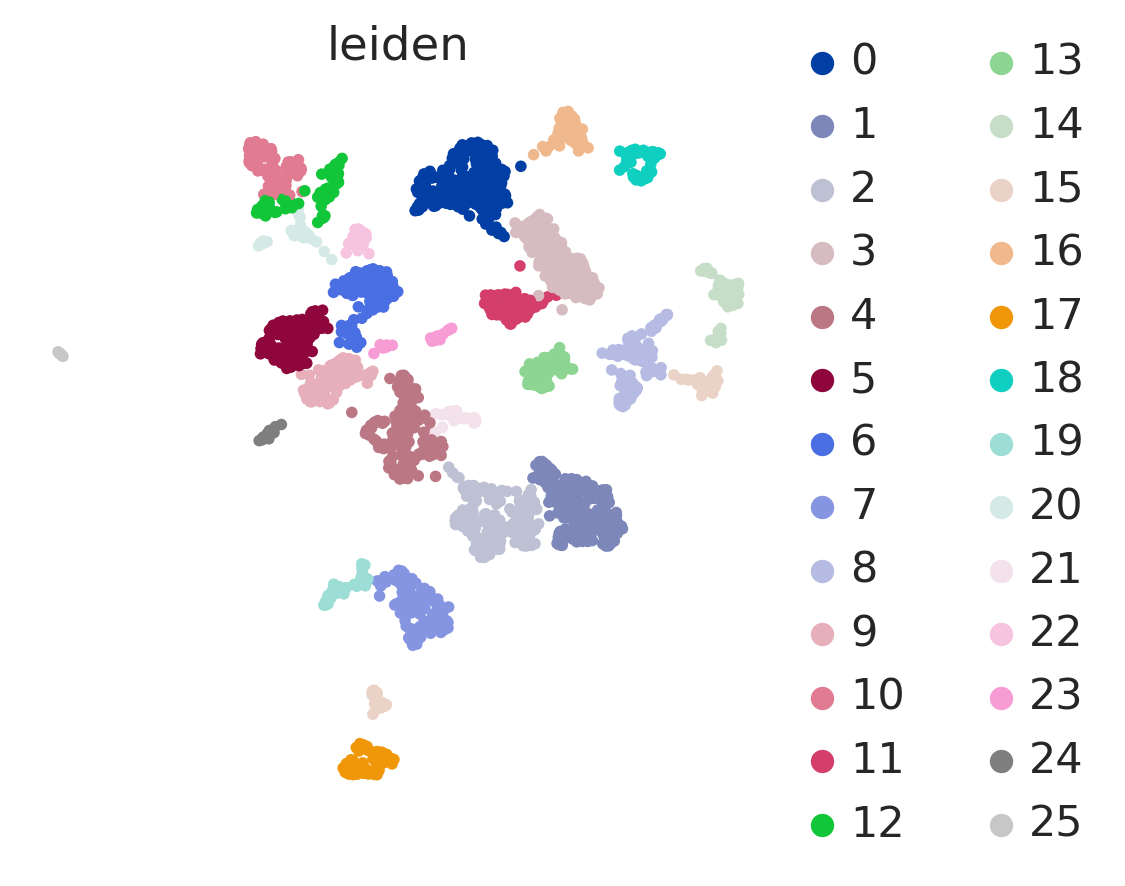

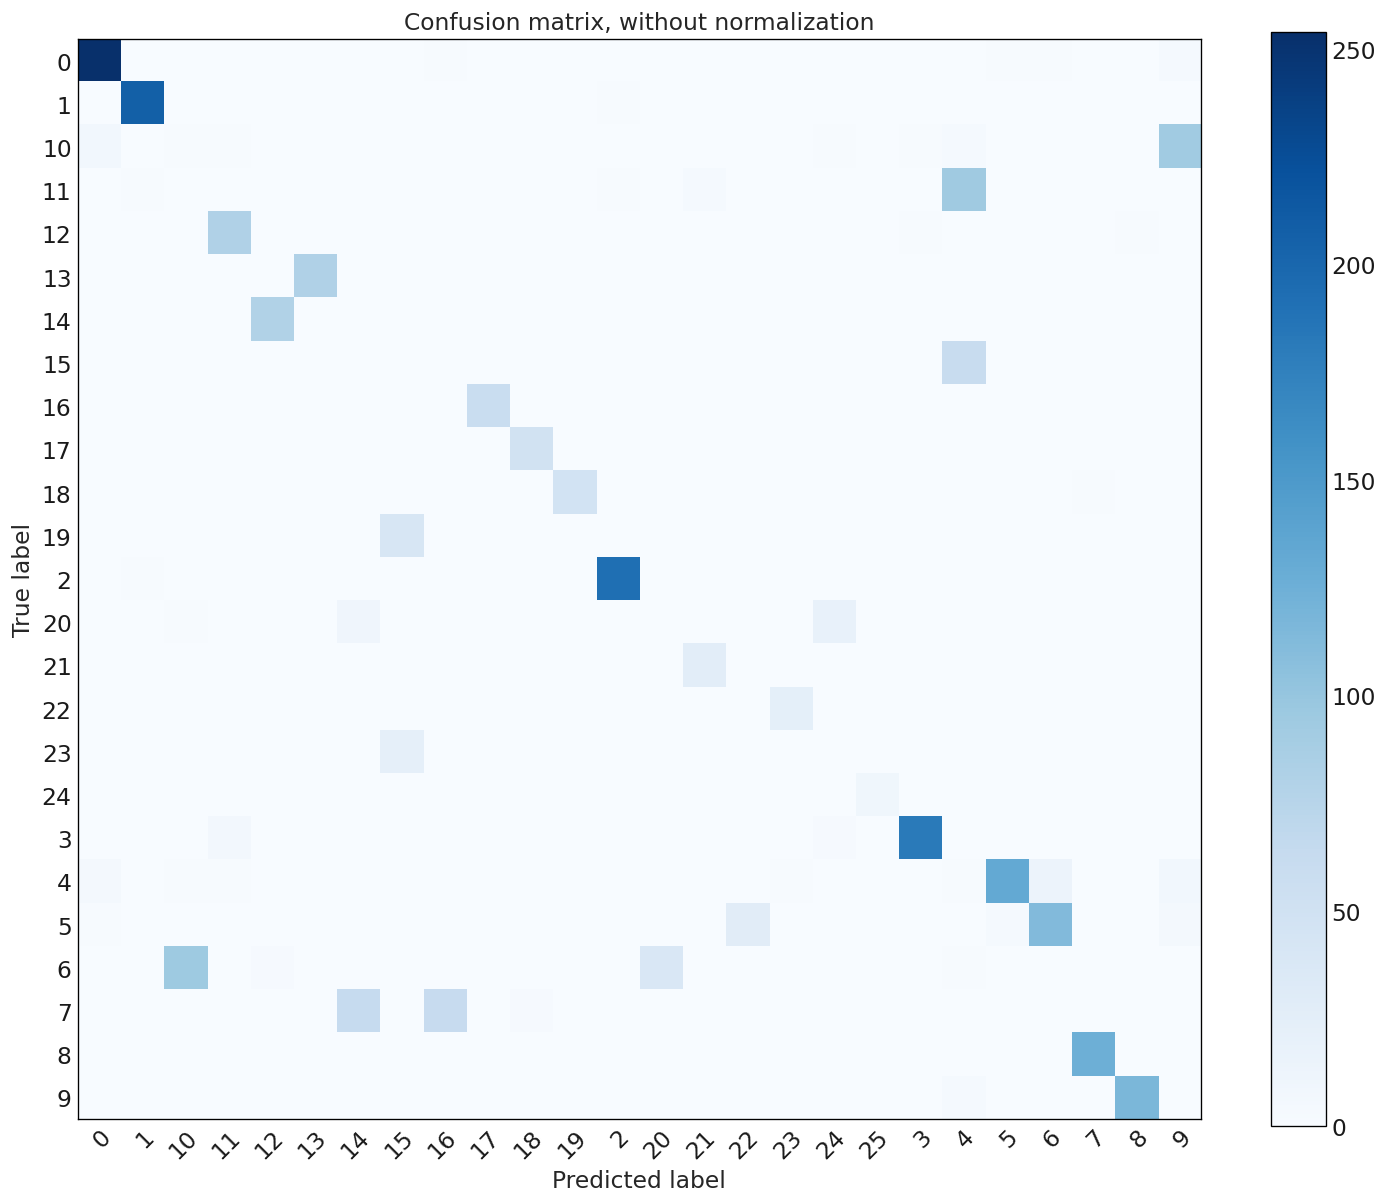

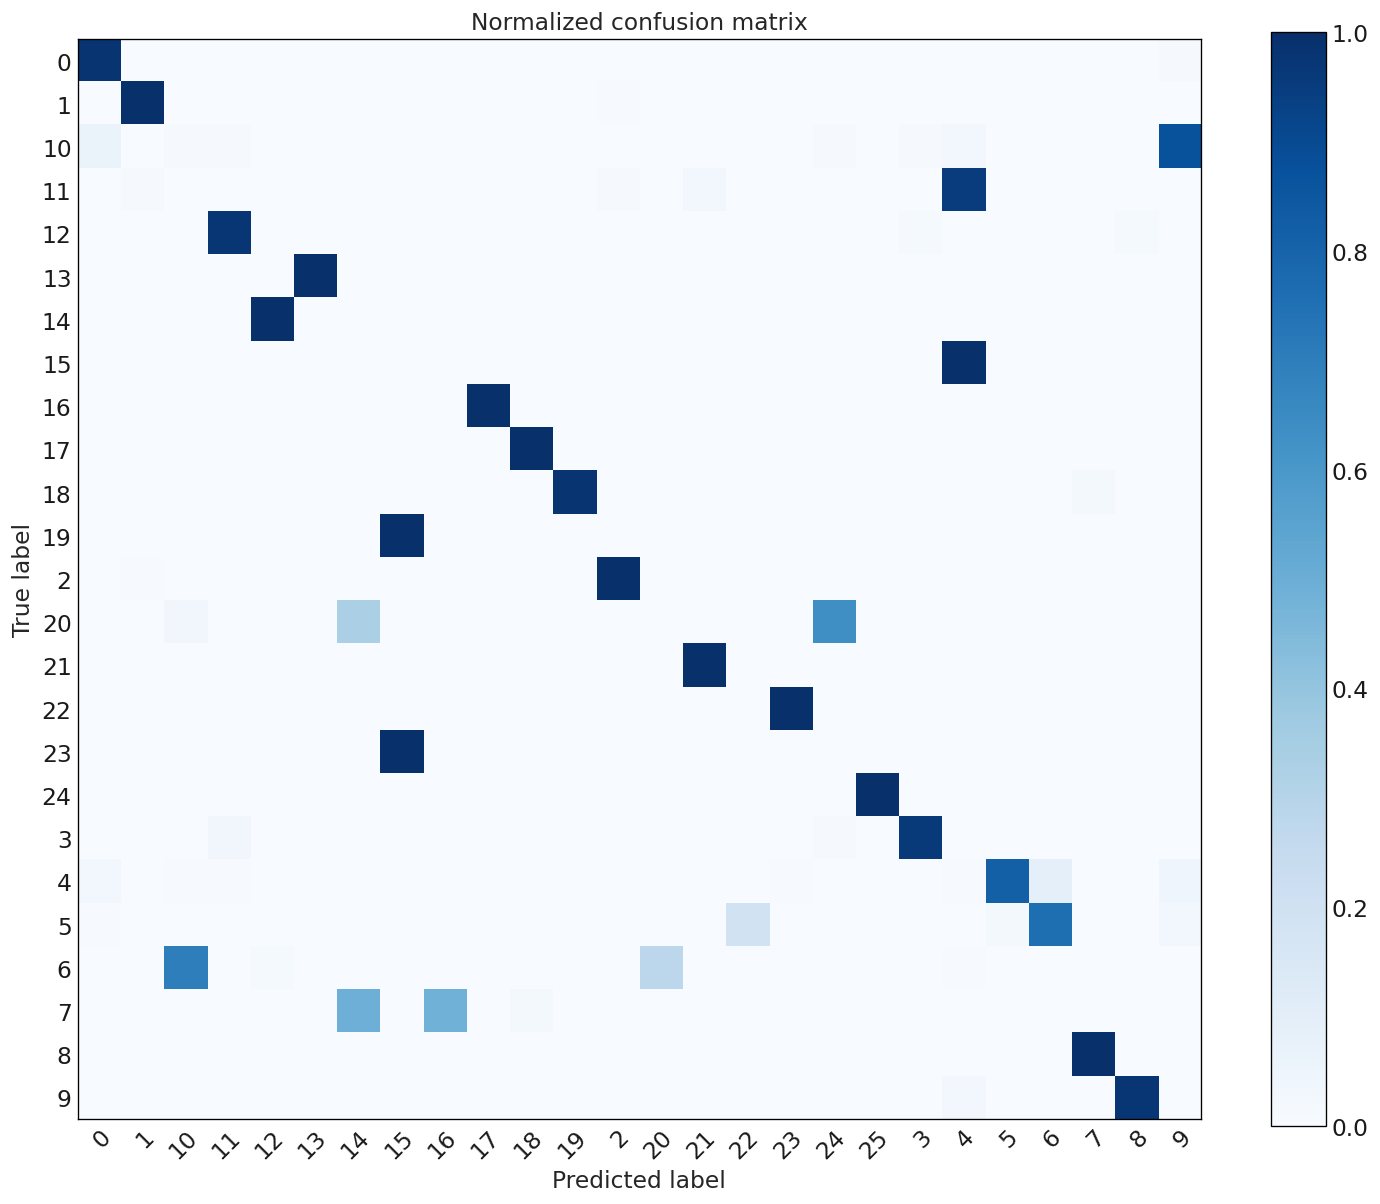

In [31]:
bc.tl.report(adata_pred=adata, celltype='leiden_reg_before_hvg', method='without_regress_out', analysis_name=analysis_name,
                        test_dataset='adata_new', name_prediction='leiden', name_report='compare_leiden', use_raw=False,
                        remove_nonshared=False, clustering='leiden', asymmetric_matrix=True, delimiter='\t', verbose=True)